# ***Who Grade Binary Classification***

This notebook shows the process of classifying samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from typing import Tuple
from tqdm import tqdm
from pathlib import Path
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# INPUT_TYPE = "all"
# INPUT_TYPE = "600_900"
# INPUT_TYPE = "50_400"
INPUT_TYPE = "top_1000"

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset
DHG_PATH = "./DHG/"
# Define folder that contains the preprocessed dataset
LEVEL_2_PATH = f"{DHG_PATH}/level_2"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"./models/binary_who_grade_classification"
# Define path to save plots
FIGURES_PATH = "./figures/binary_who_grade_classification"
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define spectra dimension
SPECTRA_DIM = {
    "all": 92000,
    "600_900": 24000,
    "50_400": 28000,
    "top_1000": 1000
}
# Define number of epochs
EPOCHS = 100
# Define batch size
BATCH_SIZE = 256
# Define learning rate
LEARNING_RATE = 1e-3

### ***Creating output folder***

Next, let's create the output folder:

In [4]:
# Create output folder if doesn't exist
Path(FIGURES_PATH).mkdir(parents=True, exist_ok=True)
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [5]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)

# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all images:

In [6]:
# Create lists to store each spectra's info
spectras_info = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(LEVEL_2_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Threshold image
    thresh_img = np.load(
        os.path.join(LEVEL_2_PATH, f"{row.sample_file_name}.npy")
    )

    # Loop over each spectra
    spectra_info = []
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Append spectra info
      spectras_info.append(
          [
              row.sample_file_name, row.sample_type, row.sample_number,
              row.histology, row.who_grade, x, y, idx,
              (True if thresh_img[y - 1, x - 1] else False)
          ]
      )

# Convert to data frame
spectras_info = pd.DataFrame(
    spectras_info, columns=[
        "file_name", "sample_type", "sample_number", "histology", "who_grade",
        "x_coordinate", "y_coordinate", "idx", "is_tissue"
    ]
)
spectras_info["label"] = (spectras_info["who_grade"] > 2).astype(int)

# Separate section and replica
s_spectras_info = spectras_info[spectras_info.sample_type == "section"]
r_spectras_info = spectras_info[spectras_info.sample_type == "replica"]

MSI Loop: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [7]:
# Opening parsers
parsers = {
    file_name:
    ImzMLParser(os.path.join(LEVEL_2_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [8]:
def map_record(
    file_name: tf.Tensor, idx: tf.Tensor, label: tf.Tensor,
    filter_spectra: tf.Tensor
) -> Tuple[np.ndarray, int]:
  """Function to map a record to model input (spectra) and output (label).

  Args:
      file_name (tf.Tensor): Record file name to get spectra.
      idx (tf.Tensor): Record index to get spectra.
      label (tf.Tensor): Record label.
      filter_spectra (tf.Tensor): How to filter intensities spectra.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  file_name, idx, label, filter_spectra = (
      file_name.numpy(), idx.numpy(), label.numpy(), filter_spectra.numpy()
  )

  # Decode bytes to str
  file_name = file_name.decode('utf-8')

  # Reading spectra from parser
  _, spectra = parsers[file_name].getspectrum(idx)

  # Return spectra and label
  return (spectra[filter_spectra], label)


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM[INPUT_TYPE]])
  y.set_shape([])
  return x, y


def create_ds(
    file_names: np.ndarray, indexes: np.ndarray, labels: np.ndarray,
    batch_size: int, shuffle: bool, filter_spectra: np.ndarray
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      file_names (np.ndarray): file names of the dataset.
      indexes (np.ndarray): indexes of the dataset.
      labels (np.ndarray): labels of the dataset.
      batch_size (int): batch size.
      shuffle (bool): flag to indicate if to shuffle or not.
      filter_spectra (tf.Tensor): indexes of intensities to take in spectra.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset
  ds = tf.data.Dataset.from_tensor_slices((file_names, indexes, labels))
  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(file_names), seed=SEED)
  # Map record to model input
  ds = ds.map(
      lambda i, j, k: tf.py_function(
          func=map_record, inp=[i, j, k, filter_spectra], Tout=
          [tf.float32, tf.int32]
      )
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batch's to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [9]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM[INPUT_TYPE],)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.LeakyReLU(alpha=0.2),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1024),
      layers.LeakyReLU(alpha=0.2),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(512),
      layers.LeakyReLU(alpha=0.2),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Section classification:***
Next, let's apply classification on section samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [ ]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in s_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Filter training data
  s_spectras_info_train = s_spectras_info.loc[train_filter]

  # Get minimum number of samples between 0 and 1 for under sampling
  min_count = np.min(
      [
          (s_spectras_info_train.label == 0).sum(),
          (s_spectras_info_train.label == 1).sum()
      ]
  )

  # Get indexes of zero and 1 samples
  zero_index = s_spectras_info_train[s_spectras_info_train.label == 0].index
  one_index = s_spectras_info_train[s_spectras_info_train.label == 1].index

  # Sample random minimum number of indexes of zero and 1 samples
  random_zero_index = np.random.choice(zero_index, min_count, replace=False)
  random_one_index = np.random.choice(one_index, min_count, replace=False)

  # Filter data after sampling for balance
  s_spectras_info_train = s_spectras_info_train.loc[np.concatenate(
      (random_zero_index, random_one_index)
  )]

  # Get x and y data for training
  X = s_spectras_info_train[["file_name", "idx"]]
  y = s_spectras_info_train["label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Get common mzs
  mzs = parsers[X_train.iloc[0].file_name].getspectrum(X_train.iloc[0].idx)[0]

  # Create filter for spectra
  filter_spectra = False
  if INPUT_TYPE == "all":
    filter_spectra = True
  elif INPUT_TYPE == "600_900":
    filter_spectra = ((mzs >= 600) & (mzs <= 900))
  elif INPUT_TYPE == "50_400":
    filter_spectra = ((mzs >= 50) & (mzs <= 400))
  elif INPUT_TYPE == "top_1000":
    # Get mean spectra of train data
    mean_spec = 0
    for index, row in X_train.iterrows():
      mean_spec += parsers[row.file_name].getspectrum(row.idx)[1]
    mean_spec /= X_train.shape[0]

    # Get indexes of top mzs of variance spectra in range 600-900
    filter_spectra = mean_spec[(mzs >= 600) &
                               (mzs <= 900)].argsort()[-1000:][::-1]
    filter_spectra += np.where((mzs >= 600) & (mzs <= 900))[0][0]

    # Save indexes
    np.save(
        os.path.join(
            MODELS_PATH,
            f"section_excluded_{exclude_image}_top_1000_filter.npy",
            filter_spectra
        )
    )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True, filter_spectra
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True, filter_spectra
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_loss",
      mode="min", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

In [30]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in r_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = r_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & r_spectras_info.is_tissue)

  # Filter training data
  r_spectras_info_train = r_spectras_info.loc[train_filter]

  #
  print(
      (
          f"{(r_spectras_info_train.label == 0).sum()} spectras, "
          f"{r_spectras_info_train[(r_spectras_info_train.label == 0)].file_name.unique().shape[0]} samples, "
          f"{(r_spectras_info_train.label == 1).sum()} spectras, {r_spectras_info_train[(r_spectras_info_train.label == 1)].file_name.unique().shape[0]} samples "
          f"1."
      )
  )
  """
  # Get minimum number of samples between 0 and 1 for under sampling
  min_count = np.min(
      [
          (s_spectras_info_train.label == 0).sum(),
          (s_spectras_info_train.label == 1).sum()
      ]
  )

  # Get indexes of zero and 1 samples
  zero_index = s_spectras_info_train[s_spectras_info_train.label == 0].index
  one_index = s_spectras_info_train[s_spectras_info_train.label == 1].index

  # Sample random minimum number of indexes of zero and 1 samples
  random_zero_index = np.random.choice(zero_index, min_count, replace=False)
  random_one_index = np.random.choice(one_index, min_count, replace=False)

  # Filter data after sampling for balance
  s_spectras_info_train = s_spectras_info_train.loc[np.concatenate(
      (random_zero_index, random_one_index)
  )]

  # Get x and y data for training
  X = s_spectras_info_train[["file_name", "idx"]]
  y = s_spectras_info_train["label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Get common mzs
  mzs = parsers[X_train.iloc[0].file_name].getspectrum(X_train.iloc[0].idx)[0]

  # Create filter for spectra
  filter_spectra = False
  if INPUT_TYPE == "all":
    filter_spectra = True
  elif INPUT_TYPE == "600_900":
    filter_spectra = ((mzs >= 600) & (mzs <= 900))
  elif INPUT_TYPE == "50_400":
    filter_spectra = ((mzs >= 50) & (mzs <= 400))
  elif INPUT_TYPE == "top_1000":
    # Get mean spectra of train data
    mean_spec = 0
    for index, row in X_train.iterrows():
      mean_spec += parsers[row.file_name].getspectrum(row.idx)[1]
    mean_spec /= X_train.shape[0]

    # Get indexes of top mzs of variance spectra in range 600-900
    filter_spectra = mean_spec[(mzs >= 600) &
                               (mzs <= 900)].argsort()[-1000:][::-1]
    filter_spectra += np.where((mzs >= 600) & (mzs <= 900))[0][0]

    # Save indexes
    np.save(
        os.path.join(
            MODELS_PATH,
            f"section_excluded_{exclude_image}_top_1000_filter.npy",
            filter_spectra
        )
    )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True, filter_spectra
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True, filter_spectra
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_loss",
      mode="min", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)
  """

19340 spectras, 9 samples, 25827 spectras, 15 samples 1.
21896 spectras, 10 samples, 23490 spectras, 13 samples 1.
21896 spectras, 10 samples, 20696 spectras, 13 samples 1.
20215 spectras, 9 samples, 24289 spectras, 14 samples 1.
14390 spectras, 7 samples, 25827 spectras, 15 samples 1.
14419 spectras, 6 samples, 23959 spectras, 14 samples 1.
21896 spectras, 10 samples, 22705 spectras, 12 samples 1.
19220 spectras, 9 samples, 18005 spectras, 11 samples 1.
21896 spectras, 10 samples, 21818 spectras, 13 samples 1.


In [21]:
s_metadata_df

file_name sample_file_name  sample_number sample_type  \
0         HG 11-11-12-s        HG 11_1-s             11     section   
1         HG 11-11-12-s        HG 11_2-s             11     section   
2         HG 11-11-12-s          HG 12-s             12     section   
7            HG 14-13-s          HG 14-s             14     section   
8            HG 14-13-s          HG 13-s             13     section   
11           HG 16-15-s          HG 15-s             15     section   
12           HG 16-15-s          HG 16-s             16     section   
16           HG 19-18-s          HG 19-s             19     section   
17           HG 19-18-s          HG 18-s             18     section   
23  HG 29-25-23-21-20-s          HG 20-s             20     section   
24  HG 29-25-23-21-20-s          HG 21-s             21     section   
25  HG 29-25-23-21-20-s          HG 23-s             23     section   
26  HG 29-25-23-21-20-s          HG 25-s             25     section   
27  HG 29-25-23-21-20-s          HG 29-s             29     section   
31             HG 6-7-s           HG 6-s              6     section   
32             HG 6-7-s           HG 7-s              7     section   
33    HG 8-12-5-4-3-2-s           HG 8-s              8     section   
34    HG 8-12-5-4-3-2-s        HG 12_1-s             12     section   
35    HG 8-12-5-4-3-2-s           HG 5-s              5     section   
36    HG 8-12-5-4-3-2-s           HG 4-s              4     section   
37    HG 8-12-5-4-3-2-s           HG 3-s              3     section   
38    HG 8-12-5-4-3-2-s           HG 2-s              2     section   
46            HG 9-10-s           HG 9-s              9     section   
47            HG 9-10-s          HG 10-s             10     section   
49               HG 1-s           HG 1-s              1     section   

              histology  who_grade  x_min  y_min  x_max  y_max  
0           Astrocytoma          3      0      0     74     57  
1           Astrocytoma          3     74      0    158     57  
2           Astrocytoma          4    158      0    246     57  
7           Astrocytoma          4      0      0     83     54  
8           Astrocytoma          4     83      0    147     54  
11          Astrocytoma          4      0      0     64     70  
12          Astrocytoma          1     64      0    146     70  
16   Oligodendrogliooma          2      0      0     60     53  
17          Astrocytoma          2     60      0    115     53  
23          Astrocytoma          2      0      0     90     67  
24   Oligodendrogliooma          3     90      0    155     67  
25          Astrocytoma          1    155      0    216     67  
26   Oligodendrogliooma          2    216      0    280     67  
27   Oligodendrogliooma          2    280      0    354     67  
31          Astrocytoma          4      0      0     67     45  
32          Astrocytoma          4     67      0    117     45  
33          Astrocytoma          3      0      0     82     73  
34          Astrocytoma          4     82      0    153     73  
35          Astrocytoma          4    153      0    193     73  
36          Astrocytoma          4    193      0    247     73  
37          Astrocytoma          4    247      0    305     73  
38   Oligodendrogliooma          2    305      0    359     73  
46   Oligodendrogliooma          3      0      0     62     57  
47          Astrocytoma          4     62      0    120     57  
49  Oligodendrogliooma           2      0      0     79     56

In [20]:
18626  / 5759

3.234242055912485

In [11]:
"""
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in tqdm(s_metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Get x and y data for training
  X = s_spectras_info.loc[train_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[train_filter, "label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_loss", mode="min", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(),
      metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)
"""

'\n# Define dict\'s to store validation and training metrics\ntrain_metrics = {}\nvalidation_metrics = {}\n\n# Loop over each image\nfor exclude_image, group in tqdm(s_metadata_df.groupby("file_name")):\n  # Clear graph\n  K.clear_session()\n  gc.collect()\n\n  # Get all spectra\'s in the exclude_image to exclude them\n  exclude_spectras = s_spectras_info["sample_number"].isin(\n      group.sample_number.to_list()\n  )\n\n  # Create filter for training data - does not include the excluded image\n  # and only include tissue spectra\'s\n  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)\n\n  # Get x and y data for training\n  X = s_spectras_info.loc[train_filter, ["file_name", "idx"]]\n  y = s_spectras_info.loc[train_filter, "label"]\n\n  # Split to train and validation set\n  X_train, X_val, y_train, y_val = train_test_split(\n      X, y, test_size=0.2, random_state=SEED, stratify=y\n  )\n\n  # Create data generators\n  train_generator = create_ds(\n      X_train.iloc[:,

In [12]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
train_metrics_df.to_csv(f"{FIGURES_PATH}/section_train_metrics.csv")
# Print
train_metrics_df

loss  binary_accuracy
HG 1-s               0.001779         0.999825
HG 11-11-12-s        0.000026         1.000000
HG 14-13-s           0.002115         0.999598
HG 16-15-s           0.000887         0.999888
HG 19-18-s           0.000552         1.000000
HG 29-25-23-21-20-s  0.000045         1.000000
HG 6-7-s             0.000043         1.000000
HG 8-12-5-4-3-2-s    0.000746         0.999946
HG 9-10-s            0.002209         0.999498

In [13]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
validation_metrics_df.to_csv(f"{FIGURES_PATH}/section_validation_metrics.csv")
# Print
validation_metrics_df

loss  binary_accuracy
HG 1-s               0.082739         0.970554
HG 11-11-12-s        0.044355         0.986937
HG 14-13-s           0.071298         0.976085
HG 16-15-s           0.061800         0.978037
HG 19-18-s           0.052029         0.983998
HG 29-25-23-21-20-s  0.055421         0.981337
HG 6-7-s             0.075741         0.980707
HG 8-12-5-4-3-2-s    0.044808         0.984595
HG 9-10-s            0.064261         0.978899

#### ***Evaluation on section tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [11]:
# Create filter for spectra
filter_spectra = False
if INPUT_TYPE == "all":
  filter_spectra = True
elif INPUT_TYPE == "600_900":
  filter_spectra = (mzs >= 600) & (mzs <= 900)
elif INPUT_TYPE == "50_400":
  filter_spectra = (mzs >= 50) & (mzs <= 400)
elif INPUT_TYPE == "top_1000":
  # Get mean spectra of train data
  mean_spec = 0
  for index, row in X_train.iterrows():
    mean_spec += parsers[row.file_name].getspectrum(row.idx)[1]
  mean_spec /= X_train.shape[0]

  # Get variance spectra of train data
  var = 0
  for index, row in X_train.iterrows():
    var += (parsers[row.file_name].getspectrum(row.idx)[1] - mean_spec)**2
  var /= X_train.shape[0]

  # Get indexes of top mzs of variance spectra in range 600-900
  filter_spectra = var[(mzs >= 600) & (mzs <= 900)].argsort()[-1000:][::-1]

NameError: name 'X_train' is not defined

In [10]:
import shap

# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  data = test_generator.take(1)


  explainer = shap.KernelExplainer(classification_model, data)
  shap_values = explainer.shap_values(data)


  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop:   0%|          | 0/25 [00:00<?, ?it/s]


NameError: name 'filter_spectra' is not defined

In [14]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:25<00:00,  3.42s/it]


Next, let's get some statistics about each left out section sample predictions:

In [15]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/section_section_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 11_1-s                  0.0000176719            1.0000000000   
HG 11_2-s                  0.0000265894            1.0000000000   
HG 12-s                    0.0000206325            1.0000000000   
HG 14-s                    0.0004077587            1.0000000000   
HG 13-s                    0.0000000015            0.9994758964   
HG 15-s                    0.0000000000            0.9999988079   
HG 16-s                    0.0070344005            1.0000000000   
HG 19-s                    0.0001019181            1.0000000000   
HG 18-s                    0.0000000133            0.9999989271   
HG 20-s                    0.0000062866            1.0000000000   
HG 21-s                    0.0000000610            1.0000000000   
HG 23-s                    0.0000053361            1.0000000000   
HG 25-s                    0.0001245472            1.0000000000   
HG 29-s                    0.0000000677            1.0000000000   
HG 6-s                     0.8780403733            1.0000000000   
HG 7-s                     0.0805398524            1.0000000000   
HG 8-s                     0.0003799014            0.9998114705   
HG 12_1-s                  0.0003579645            0.9999650717   
HG 5-s                     0.0020216915            0.9999855757   
HG 4-s                     0.0373352952            0.9999991655   
HG 3-s                     0.0000648428            0.9997089505   
HG 2-s                     0.0002374244            0.9996439219   
HG 9-s                     0.0000000933            0.9999879599   
HG 10-s                    0.0000000000            0.9998959303   
HG 1-s                     0.0000000001            0.9995619655   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 11_1-s                     0.9997419715             0.9296001196   
HG 11_2-s                     0.9956358075             0.7902946472   
HG 12-s                       0.9804121852             0.7996532321   
HG 14-s                       0.9549999833             0.7906759977   
HG 13-s                       0.0001589140             0.0329525433   
HG 15-s                       0.0000102558             0.1828015447   
HG 16-s                       1.0000000000             0.9912255406   
HG 19-s                       0.9689890146             0.7413943410   
HG 18-s                       0.0154500920             0.2711899281   
HG 20-s                       0.9999132752             0.9432884455   
HG 21-s                       0.9006018043             0.6611542702   
HG 23-s                       0.9884081483             0.8459379077   
HG 25-s                       0.9998517632             0.9291256666   
HG 29-s                       0.9999252558             0.9210888147   
HG 6-s                        1.0000000000             0.9994134903   
HG 7-s                        0.9999998808             0.9958475232   
HG 8-s                        0.7729393244             0.6281623244   
HG 12_1-s                     0.9601874352             0.8319580555   
HG 5-s                        0.9949009418             0.8958246112   
HG 4-s                        0.9992581010             0.9704801440   
HG 3-s                        0.6139426827             0.5486241579   
HG 2-s                        0.9214979410             0.7779303789   
HG 9-s                        0.0011905106             0.1046117917   
HG 10-s                       0.0000630860             0.1301631182   
HG 1-s                        0.0001189470             0.0678780153   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 11_1-s                  0.1974156201             1                  1  
HG 11_2-s                  0.3492890894             1           

Next, let's evaluate the classification performance image-wise:

In [16]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.560
Balanced  Accuracy: 0.486
Precision: 0.632
Recall: 0.750
F1 score: 0.686



Next, let's plot the roc curve image-wise:

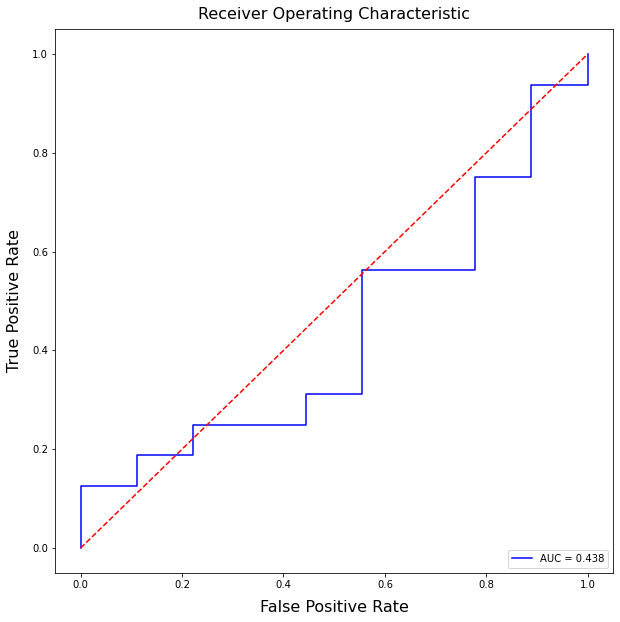

In [17]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

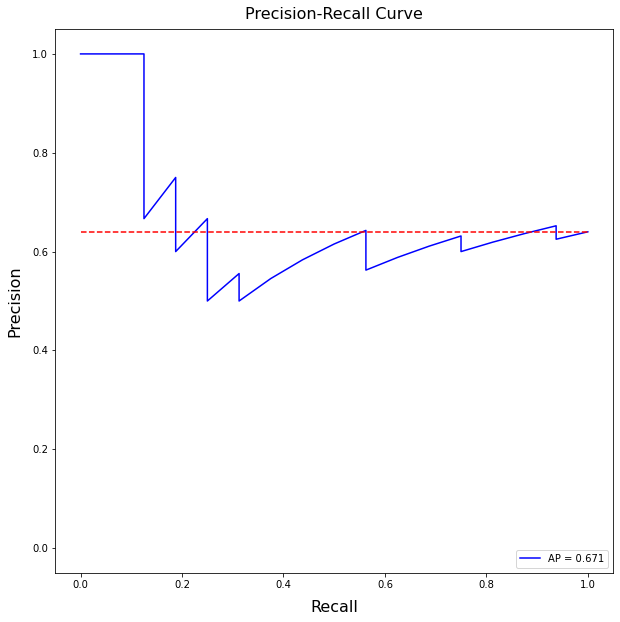

In [18]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [19]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.510
Balanced  Accuracy: 0.461
Precision: 0.662
Recall: 0.592
F1 score: 0.625



Next, let's plot the roc curve spectra-wise:

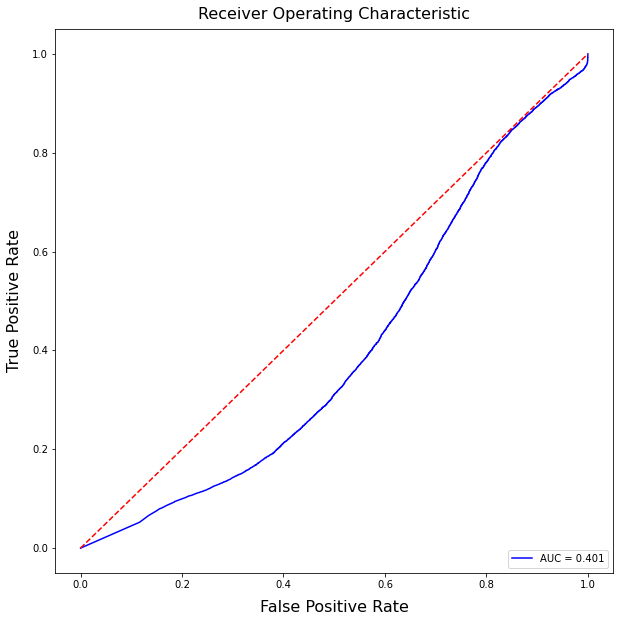

In [20]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

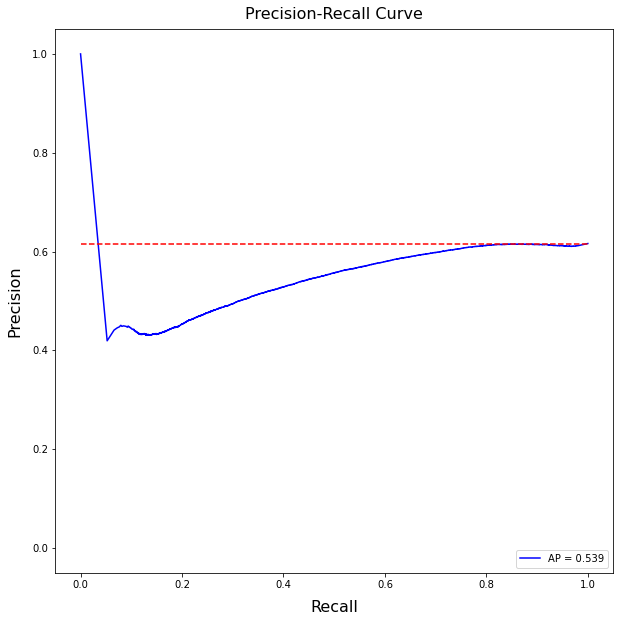

In [21]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

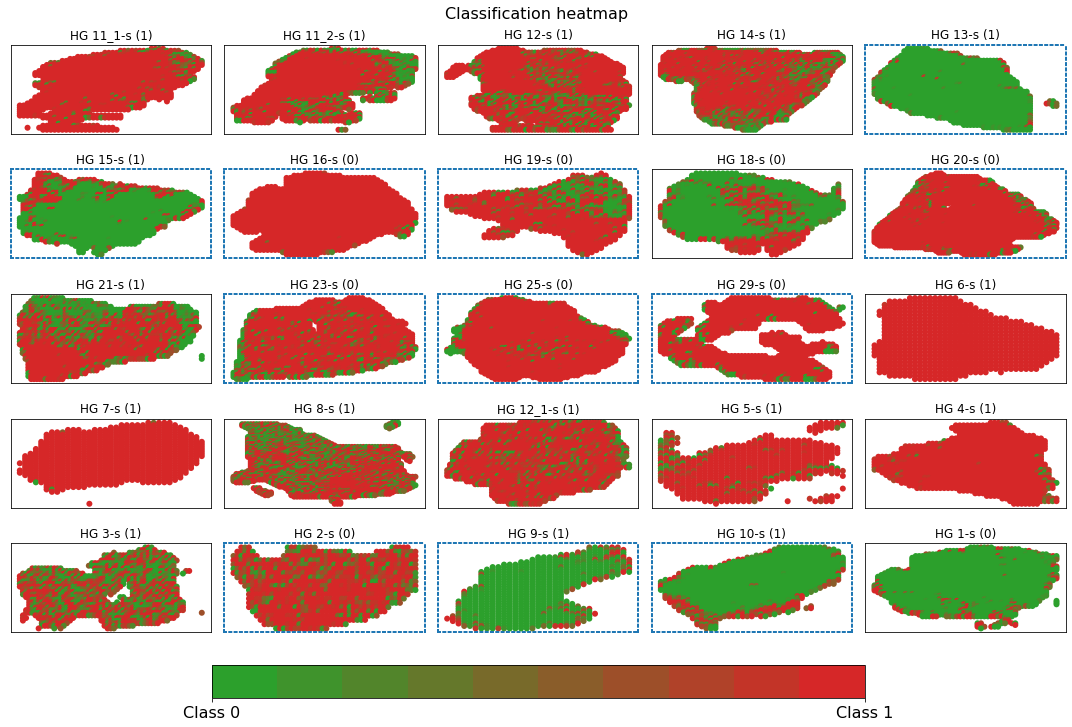

In [22]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

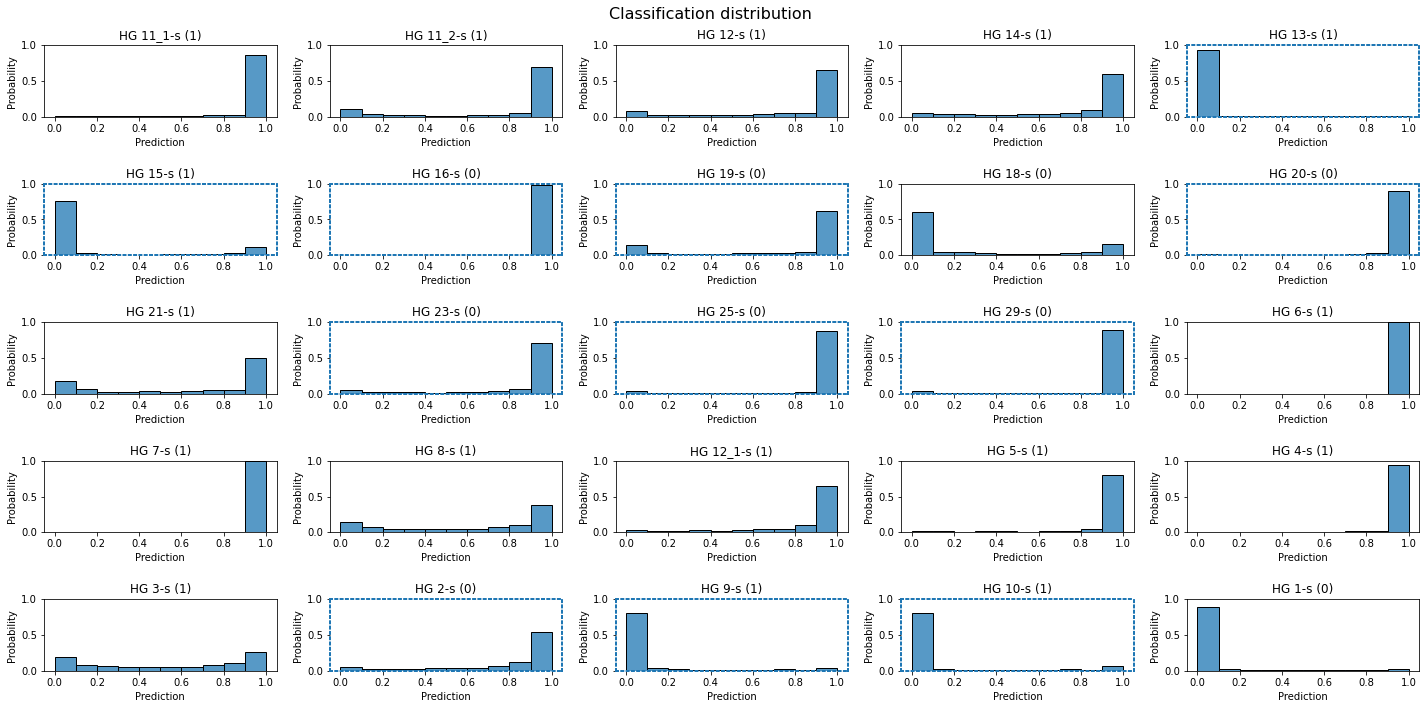

In [23]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [24]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on section non-tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [25]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      ~s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [02:08<00:00,  5.13s/it]


Next, let's get some statistics about each left out section sample predictions:

In [26]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/section_section_non_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 11_1-s                  0.0000000001            1.0000000000   
HG 11_2-s                  0.0000000078            0.9999998808   
HG 12-s                    0.0000020247            1.0000000000   
HG 14-s                    0.0000000000            1.0000000000   
HG 13-s                    0.0001408212            1.0000000000   
HG 15-s                    0.0000000002            1.0000000000   
HG 16-s                    0.0000009850            1.0000000000   
HG 19-s                    0.0000000020            1.0000000000   
HG 18-s                    0.0000013075            1.0000000000   
HG 20-s                    0.0000000168            1.0000000000   
HG 21-s                    0.0000006196            1.0000000000   
HG 23-s                    0.0000000239            1.0000000000   
HG 25-s                    0.0000000161            1.0000000000   
HG 29-s                    0.0000000057            1.0000000000   
HG 6-s                     0.0000004540            1.0000000000   
HG 7-s                     0.0000025749            0.9999997616   
HG 8-s                     0.0000012883            0.9999915361   
HG 12_1-s                  0.0000054515            0.9999731779   
HG 5-s                     0.0000075913            0.9999760389   
HG 4-s                     0.0000006378            0.9999891520   
HG 3-s                     0.0000356495            0.9999783039   
HG 2-s                     0.0000079054            0.9999644756   
HG 9-s                     0.0000004998            0.9999998808   
HG 10-s                    0.0016679975            0.9999998808   
HG 1-s                     0.0000000000            1.0000000000   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 11_1-s                     0.9786058664             0.6978557110   
HG 11_2-s                     0.9783347845             0.7142548561   
HG 12-s                       0.9823992252             0.7592620850   
HG 14-s                       0.9837877750             0.8040577173   
HG 13-s                       0.9721851349             0.7936559916   
HG 15-s                       0.8733220100             0.6364995241   
HG 16-s                       0.8994548321             0.6608747840   
HG 19-s                       0.9991251826             0.9221972823   
HG 18-s                       0.9993150234             0.9456288815   
HG 20-s                       0.8862398863             0.6157317162   
HG 21-s                       0.8601444960             0.5985475183   
HG 23-s                       0.9356445074             0.6326576471   
HG 25-s                       0.9081519842             0.6255422831   
HG 29-s                       0.7703318596             0.5611293912   
HG 6-s                        0.9116848111             0.6461704373   
HG 7-s                        0.8529188633             0.6246431470   
HG 8-s                        0.6017691493             0.5346075296   
HG 12_1-s                     0.5974931717             0.5386791825   
HG 5-s                        0.6238253117             0.5434342027   
HG 4-s                        0.6090458632             0.5402936935   
HG 3-s                        0.6180428267             0.5432349443   
HG 2-s                        0.6182233691             0.5460589528   
HG 9-s                        0.9741545916             0.7919215560   
HG 10-s                       0.9754281640             0.8313804269   
HG 1-s                        0.9713779092             0.7752788067   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 11_1-s                  0.4064373672             1                  1  
HG 11_2-s                  0.3901717067             1           

Next, let's evaluate the classification performance image-wise:

In [27]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_non_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.640
Balanced  Accuracy: 0.500
Precision: 0.640
Recall: 1.000
F1 score: 0.780



Next, let's plot the roc curve image-wise:

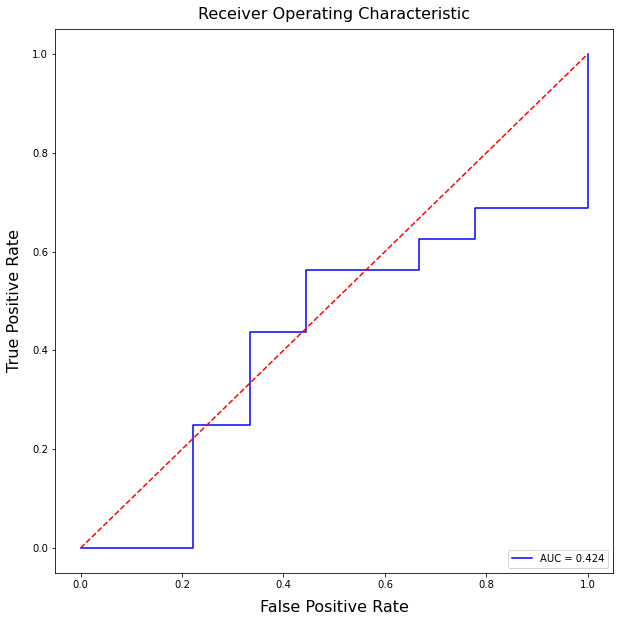

In [28]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

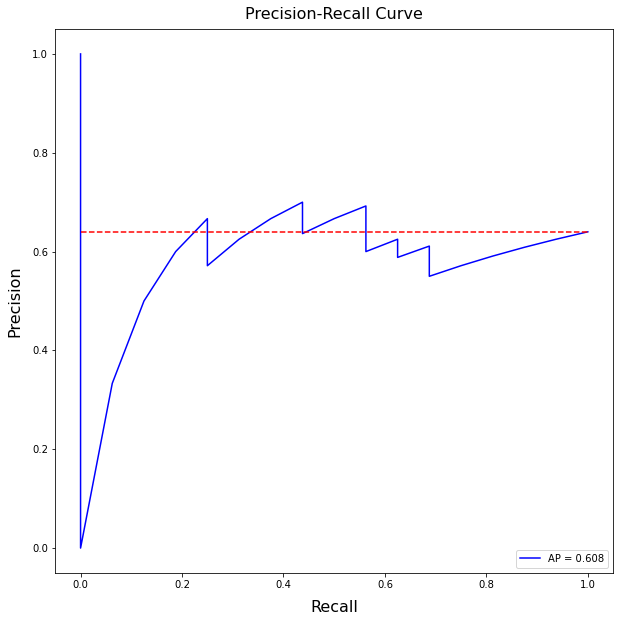

In [29]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [30]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_non_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.531
Balanced  Accuracy: 0.489
Precision: 0.661
Recall: 0.615
F1 score: 0.637



Next, let's plot the roc curve spectra-wise:

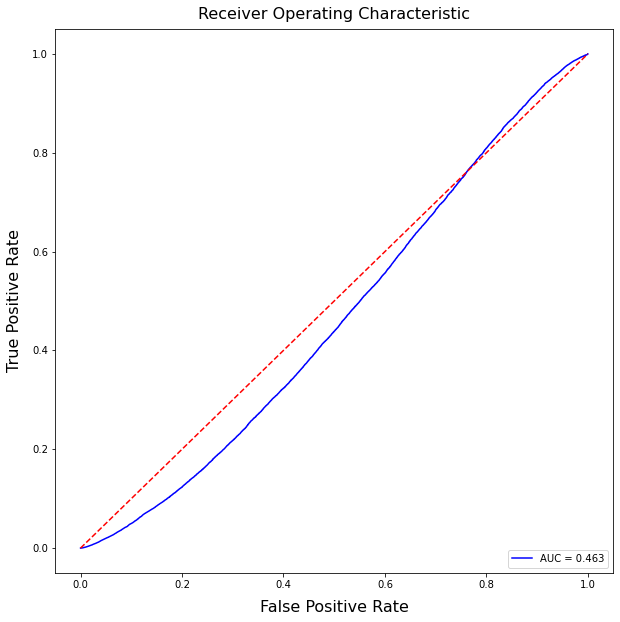

In [31]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

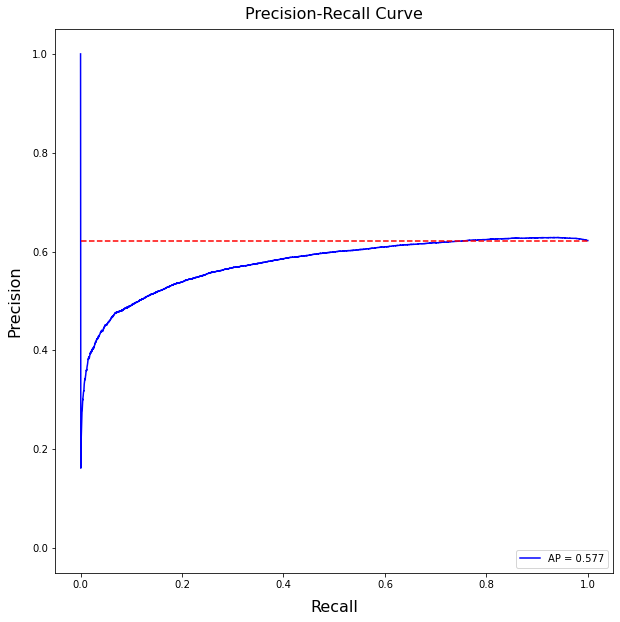

In [32]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

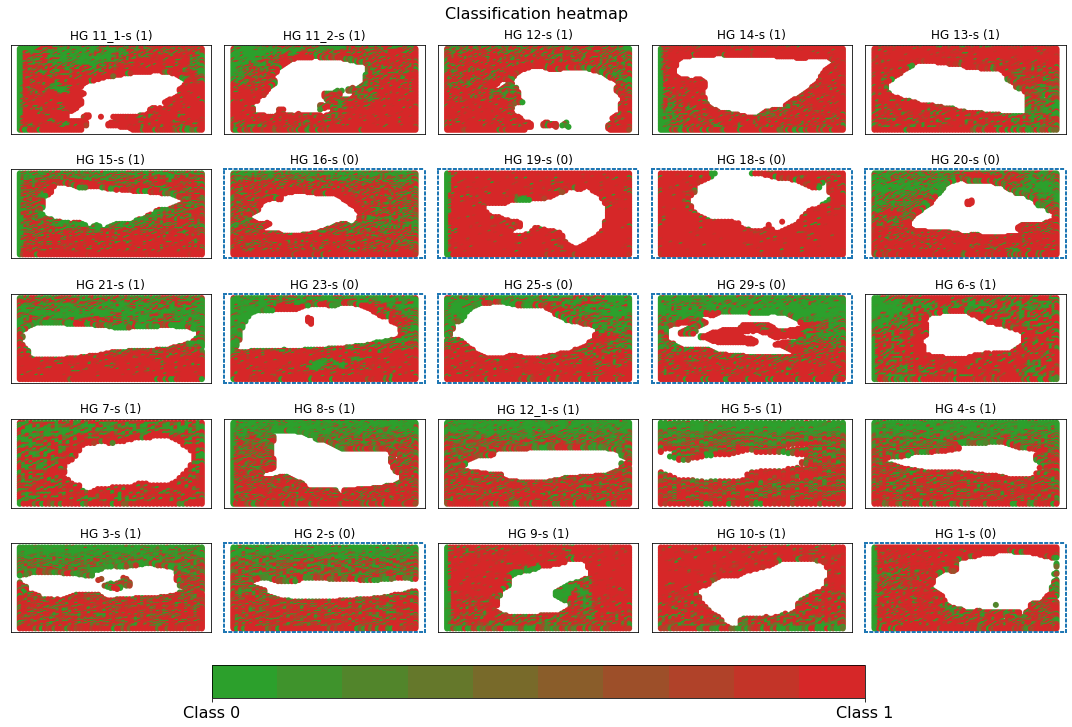

In [33]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

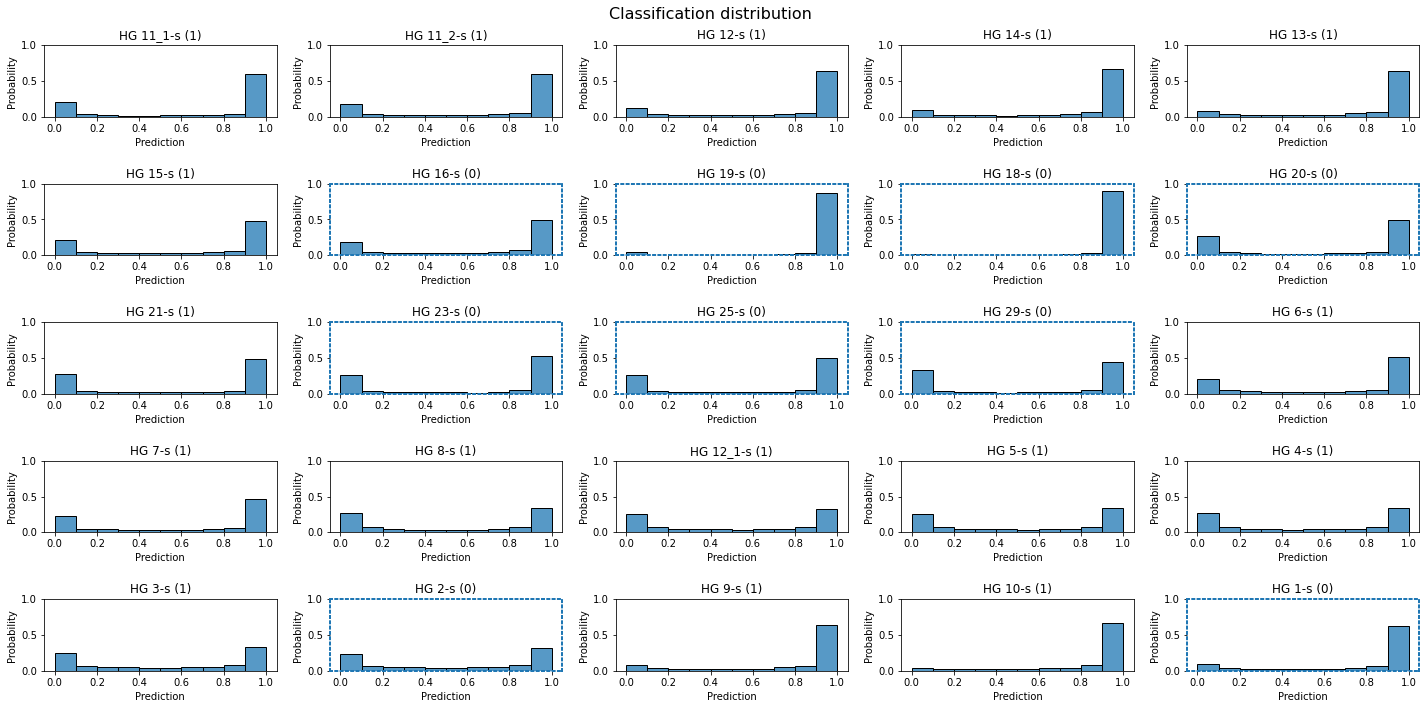

In [34]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [35]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/section_section_non_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [36]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  s_file_name = s_metadata_df[s_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{s_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:47<00:00,  4.29s/it]


Next, let's get some statistics about each left out section sample predictions:

In [37]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/section_replica_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 12-r                    0.0342192911            0.9999998808   
HG 11-r                    0.0003940980            1.0000000000   
HG 14-r                    0.3084105253            0.9999914169   
HG 13-r                    0.0000000148            0.9999272823   
HG 16-r                    0.1266506612            1.0000000000   
HG 15-r                    0.0000000000            1.0000000000   
HG 18_1-r                  0.0000018391            1.0000000000   
HG 19-r                    0.0000009675            1.0000000000   
HG 18_2-r                  0.0000041274            1.0000000000   
HG 20-r                    0.0000010301            1.0000000000   
HG 21-r                    0.0000000000            1.0000000000   
HG 23-r                    0.0000157802            0.9999991655   
HG 25-r                    0.0001992775            1.0000000000   
HG 29-r                    0.0061873724            0.9999995232   
HG 6_1-r                   0.5941684842            0.9999966621   
HG 6_2-r                   0.0003418392            1.0000000000   
HG 7-r                     0.0000255997            1.0000000000   
HG 8-r                     0.0010692262            0.9994193316   
HG 5-r                     0.0000010267            0.9999574423   
HG 4-r                     0.0022128841            0.9999082088   
HG 3-r                     0.0000002973            0.9998468161   
HG 2-r                     0.0000010862            0.9991436005   
HG 9-r                     0.6081984639            0.9999997616   
HG 10-r                    0.6164326072            1.0000000000   
HG 1-r                     0.0031035864            0.9999945164   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 12-r                       0.9825099707             0.9162609577   
HG 11-r                       0.9972201586             0.8300145864   
HG 14-r                       0.9950746894             0.9834204912   
HG 13-r                       0.9963716269             0.9907075167   
HG 16-r                       0.9999721050             0.9964668155   
HG 15-r                       0.9783905745             0.8312507272   
HG 18_1-r                     0.9451476932             0.8844096065   
HG 19-r                       0.9594607353             0.8720321655   
HG 18_2-r                     0.7782725096             0.6992755532   
HG 20-r                       0.9997095466             0.9302448630   
HG 21-r                       0.9881963730             0.8122122288   
HG 23-r                       0.9721950293             0.8008468747   
HG 25-r                       0.9903338552             0.8602418303   
HG 29-r                       0.9960837364             0.9228271246   
HG 6_1-r                      0.9994153976             0.9953261614   
HG 6_2-r                      0.9994905591             0.9502724409   
HG 7-r                        0.9997301698             0.9704321623   
HG 8-r                        0.8465698957             0.7378203273   
HG 5-r                        0.9750948548             0.8671945930   
HG 4-r                        0.9878721237             0.9378489256   
HG 3-r                        0.8701221347             0.7123882174   
HG 2-r                        0.8507434130             0.7468215823   
HG 9-r                        0.9992862344             0.9945279360   
HG 10-r                       0.9999952316             0.9974778295   
HG 1-r                        0.9172564745             0.8139069676   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 12-r                    0.1536497772             1                  1  
HG 11-r                    0.3130957782             1           

Next, let's evaluate the classification performance image-wise:

In [38]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_replica_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.600
Balanced  Accuracy: 0.500
Precision: 0.600
Recall: 1.000
F1 score: 0.750



Next, let's plot the roc curve image-wise:

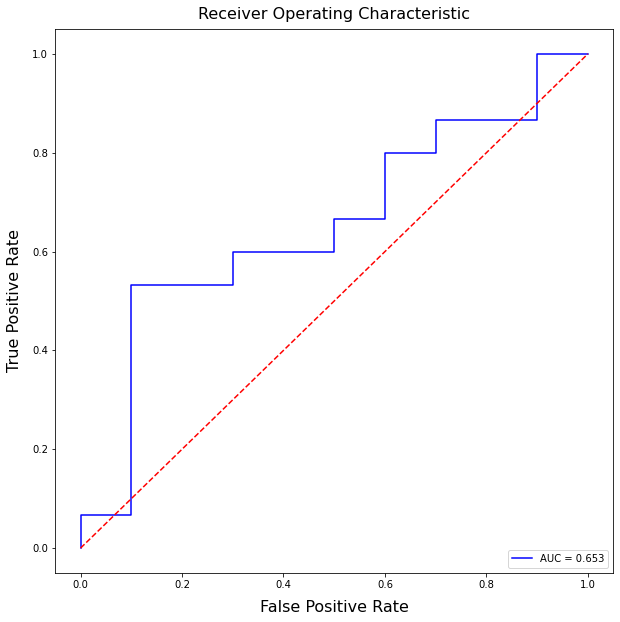

In [39]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

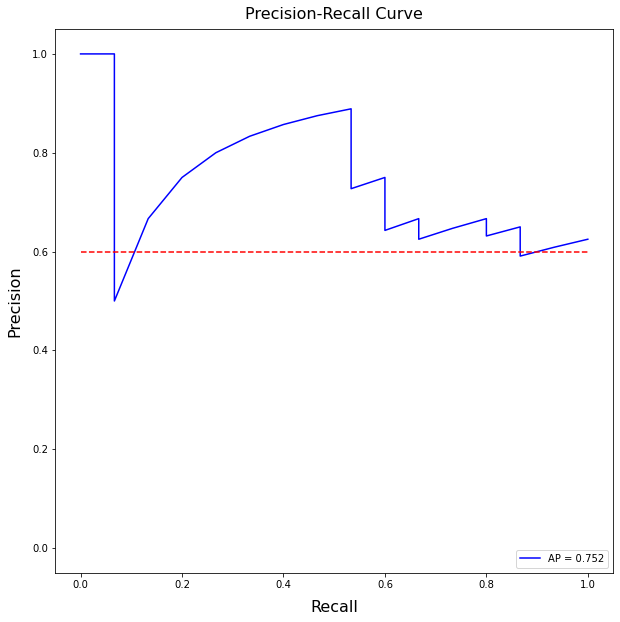

In [40]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [41]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_replica_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.547
Balanced  Accuracy: 0.539
Precision: 0.911
Recall: 0.549
F1 score: 0.685



Next, let's plot the roc curve spectra-wise:

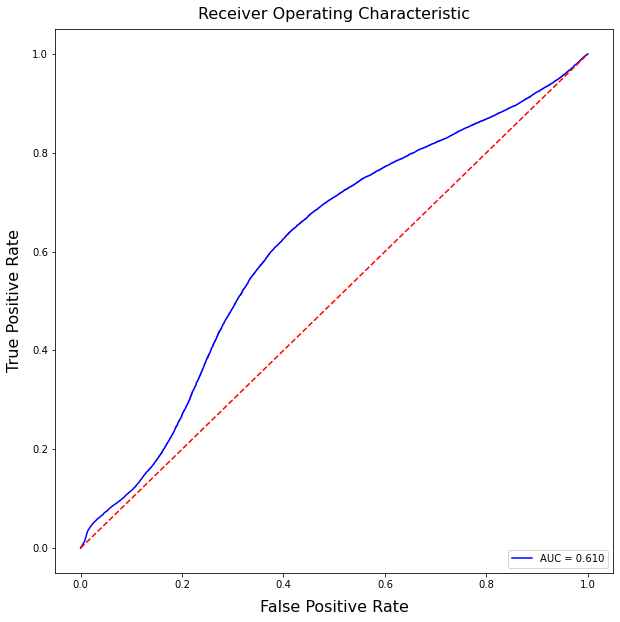

In [42]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

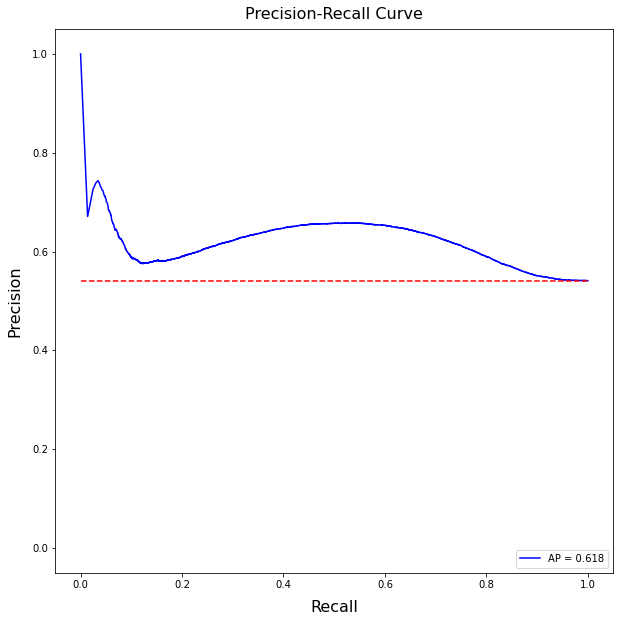

In [43]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

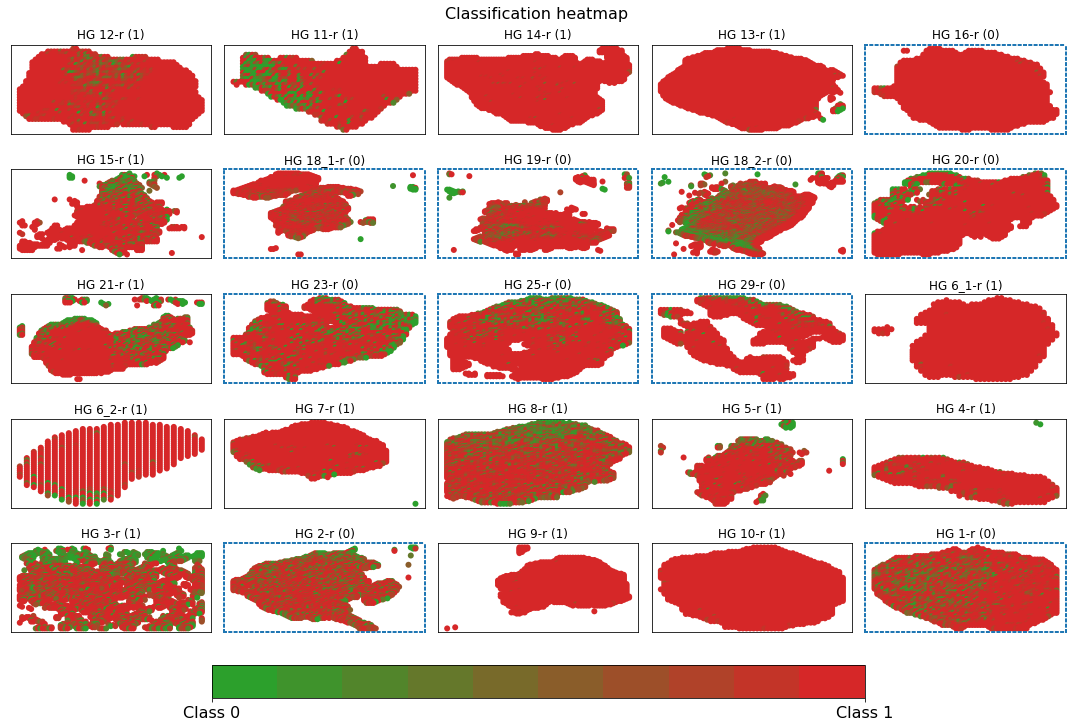

In [44]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

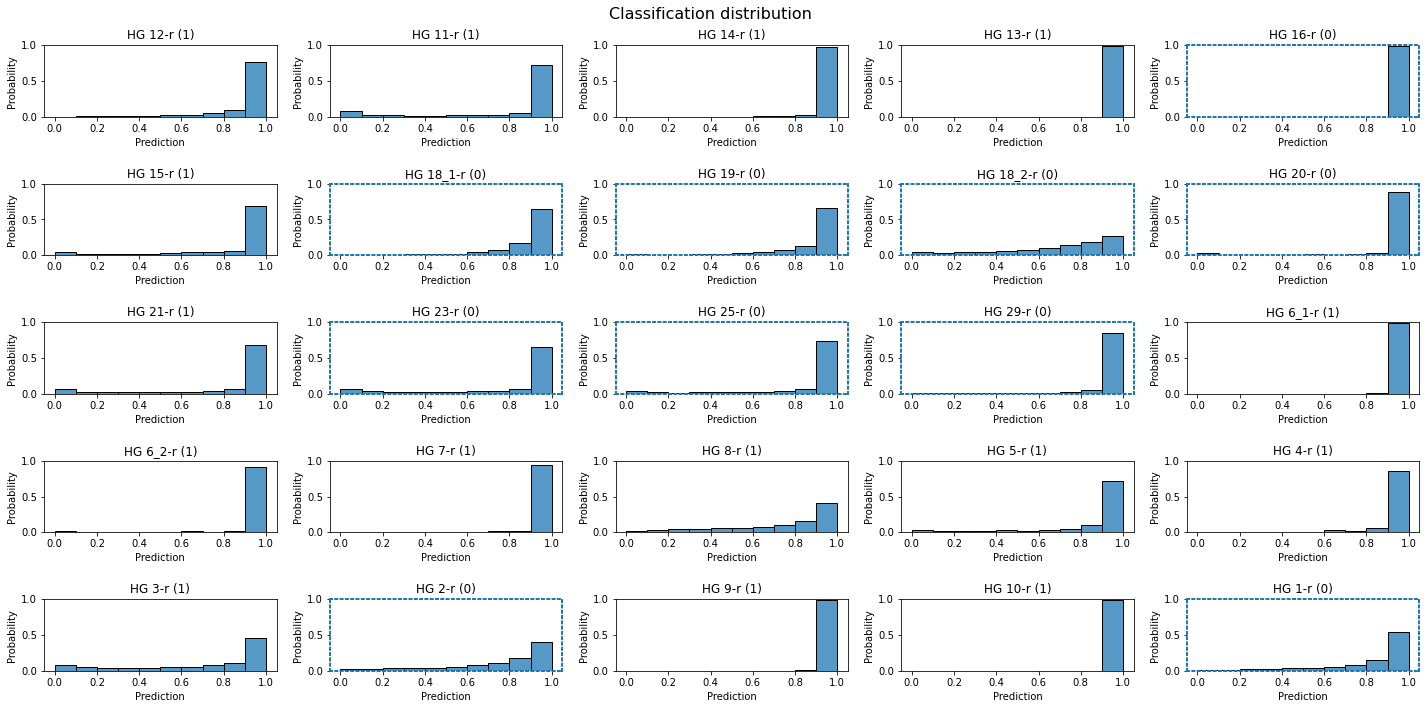

In [45]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [46]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/section_replica_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica non-tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [47]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  s_file_name = s_metadata_df[s_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      ~r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{s_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [02:28<00:00,  5.96s/it]


Next, let's get some statistics about each left out section sample predictions:

In [48]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/section_replica_non_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 12-r                    0.0000000000            1.0000000000   
HG 11-r                    0.0000000044            1.0000000000   
HG 14-r                    0.0000000047            1.0000000000   
HG 13-r                    0.0000000189            1.0000000000   
HG 16-r                    0.0000000000            1.0000000000   
HG 15-r                    0.0000000000            1.0000000000   
HG 18_1-r                  0.0000000002            1.0000000000   
HG 19-r                    0.0000000000            1.0000000000   
HG 18_2-r                  0.0000000109            1.0000000000   
HG 20-r                    0.0000000000            1.0000000000   
HG 21-r                    0.0000000000            1.0000000000   
HG 23-r                    0.0000000002            1.0000000000   
HG 25-r                    0.0000000000            1.0000000000   
HG 29-r                    0.0000000000            1.0000000000   
HG 6_1-r                   0.0000000000            1.0000000000   
HG 6_2-r                   0.0000000000            1.0000000000   
HG 7-r                     0.0000000000            1.0000000000   
HG 8-r                     0.0000000012            0.9999475479   
HG 5-r                     0.0000000001            0.9999977350   
HG 4-r                     0.0000000000            0.9999864101   
HG 3-r                     0.0000000016            0.9999618530   
HG 2-r                     0.0000000142            0.9999818802   
HG 9-r                     0.0000000000            1.0000000000   
HG 10-r                    0.0000000000            1.0000000000   
HG 1-r                     0.0000000002            1.0000000000   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 12-r                       0.9669674635             0.7836991549   
HG 11-r                       0.8770064712             0.6303840280   
HG 14-r                       0.9795925021             0.7951481342   
HG 13-r                       0.9798053503             0.8539604545   
HG 16-r                       0.9596986771             0.7441516519   
HG 15-r                       0.9507295489             0.7242282033   
HG 18_1-r                     0.9749377370             0.8184545040   
HG 19-r                       0.9948549271             0.8769946098   
HG 18_2-r                     0.9978754520             0.8480386138   
HG 20-r                       0.9835867286             0.6332709789   
HG 21-r                       0.9662058353             0.6956738830   
HG 23-r                       0.9121826887             0.6765419245   
HG 25-r                       0.8712316751             0.5868950486   
HG 29-r                       0.9697639942             0.6843923926   
HG 6_1-r                      0.9940893650             0.8716560602   
HG 6_2-r                      0.9701349735             0.7301206589   
HG 7-r                        0.9672051668             0.7123049498   
HG 8-r                        0.8081545830             0.6402401328   
HG 5-r                        0.7398424745             0.6125829816   
HG 4-r                        0.8279688954             0.6426677108   
HG 3-r                        0.7696798444             0.6105218530   
HG 2-r                        0.7931096554             0.6476004124   
HG 9-r                        0.9787951708             0.8775507808   
HG 10-r                       0.9722988009             0.7799516916   
HG 1-r                        0.9652175307             0.7808820605   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 12-r                    0.3300020993             1                  1  
HG 11-r                    0.4125353098             1           

Next, let's evaluate the classification performance image-wise:

In [49]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_replica_non_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.600
Balanced  Accuracy: 0.500
Precision: 0.600
Recall: 1.000
F1 score: 0.750



Next, let's plot the roc curve image-wise:

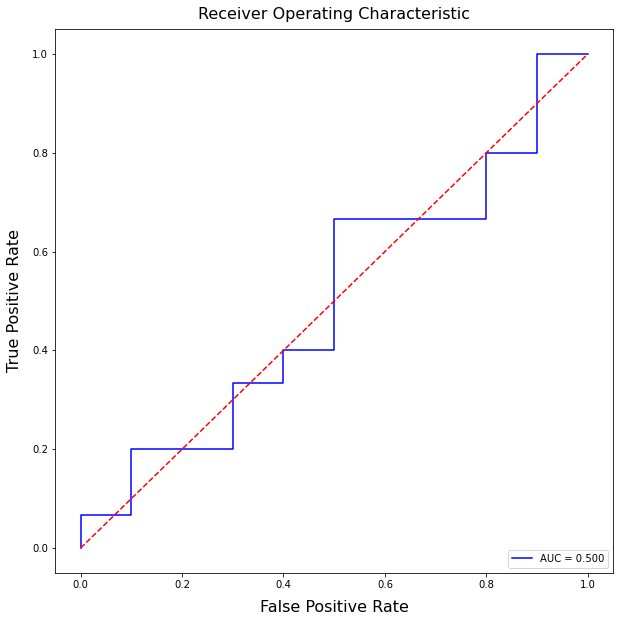

In [50]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

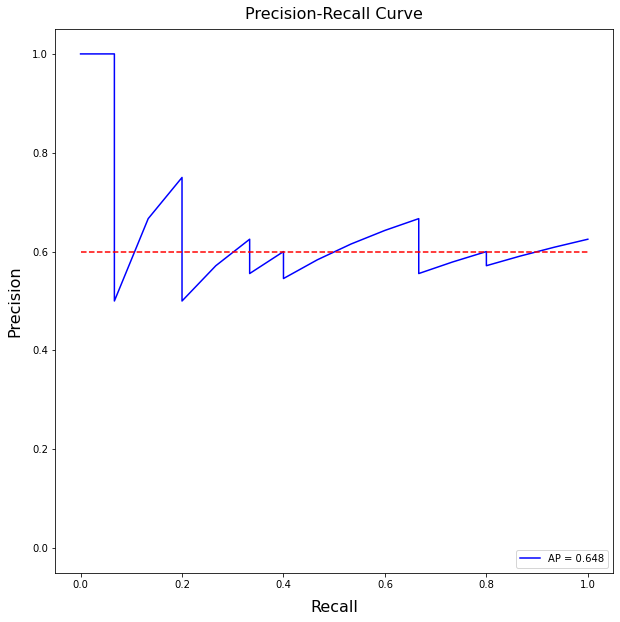

In [51]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [52]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_replica_non_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.545
Balanced  Accuracy: 0.501
Precision: 0.763
Recall: 0.584
F1 score: 0.662



Next, let's plot the roc curve spectra-wise:

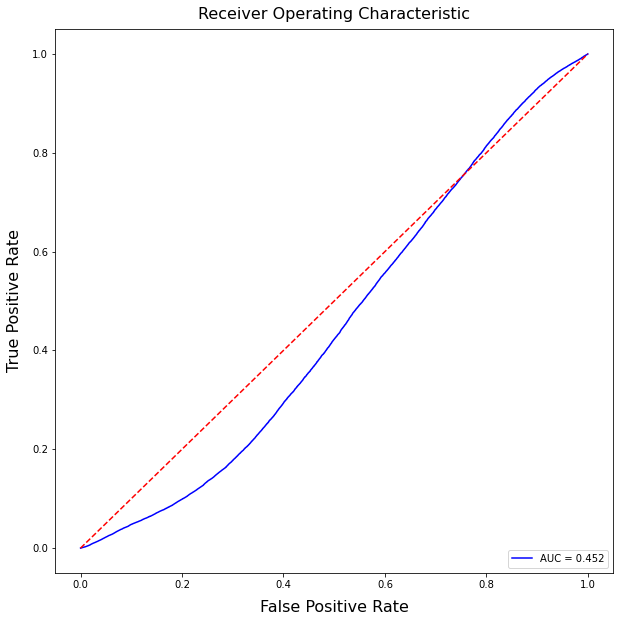

In [53]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

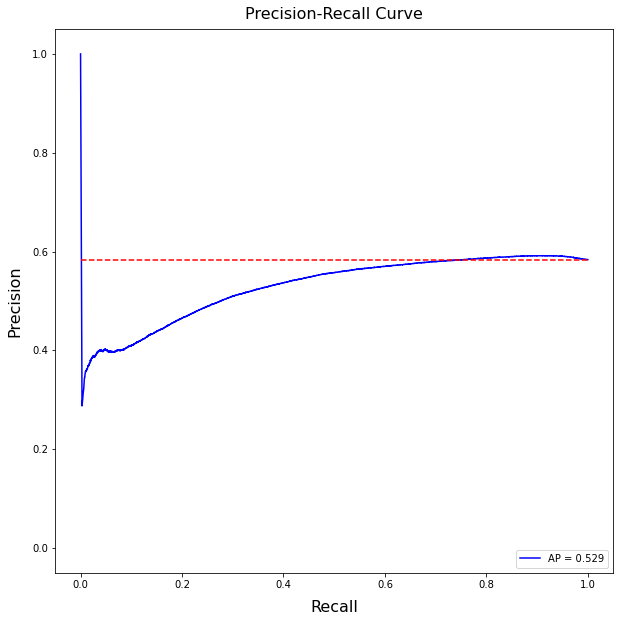

In [54]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

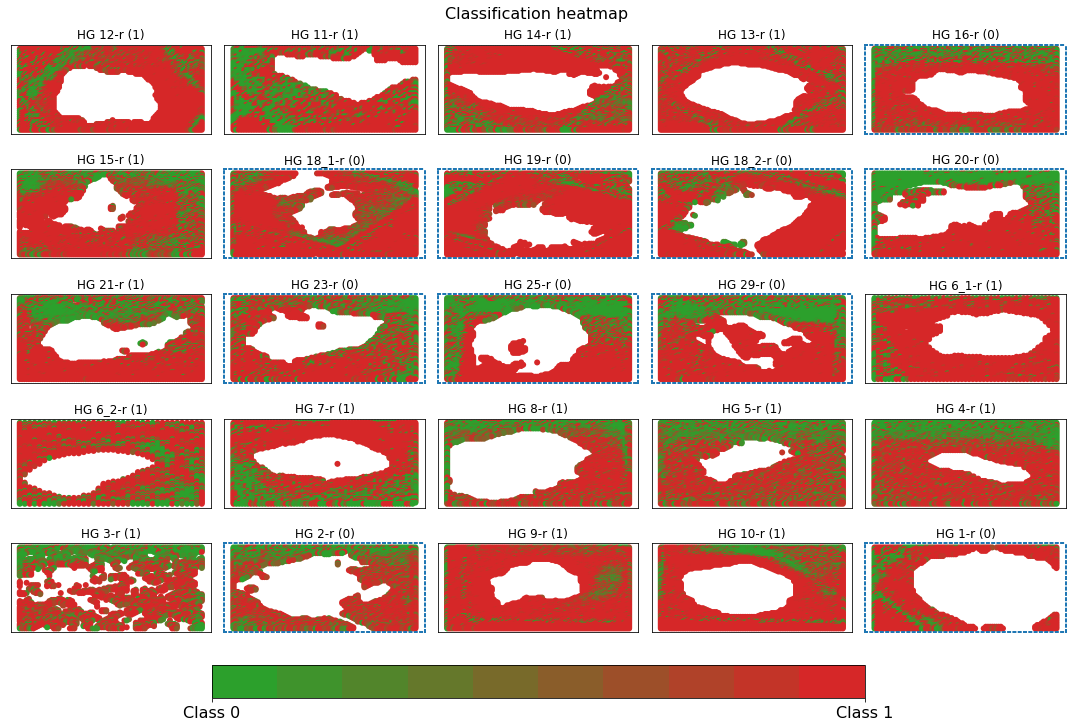

In [55]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

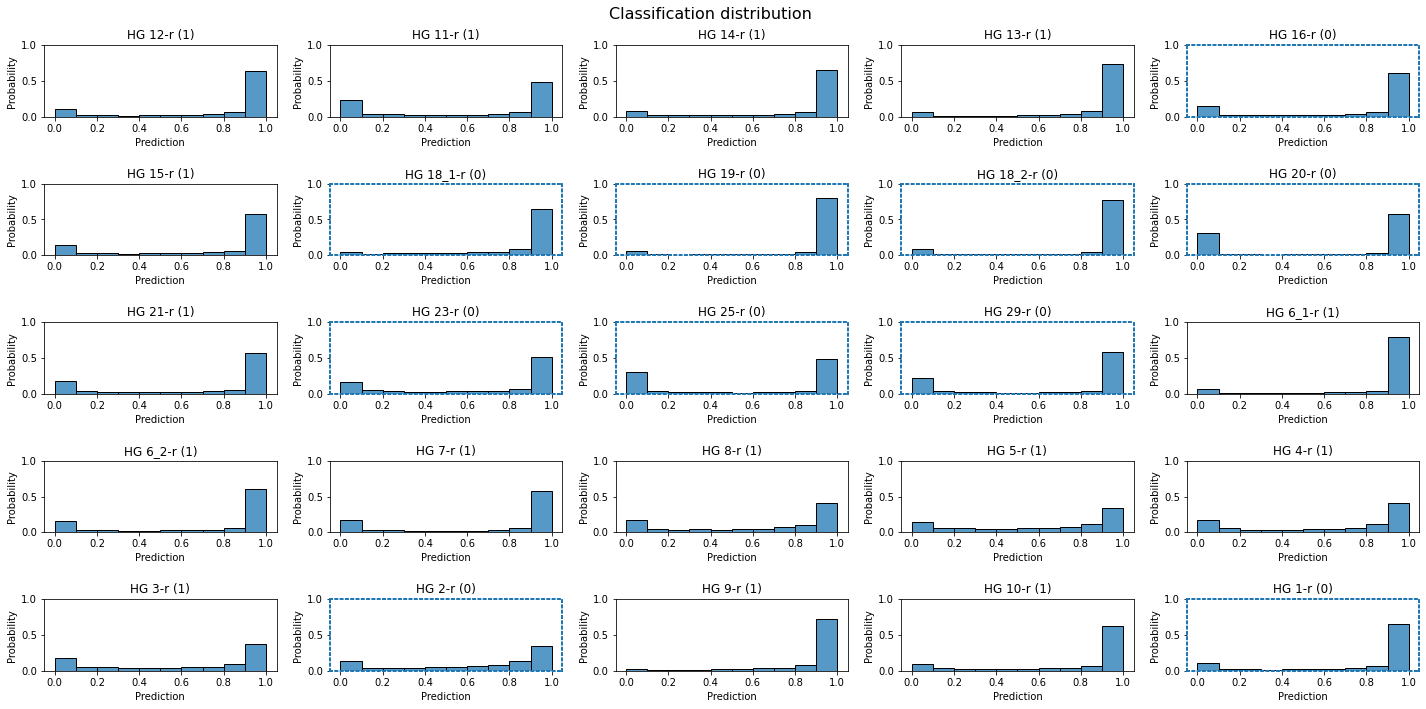

In [56]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_replica_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [57]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/section_replica_non_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***Replica classification:***
Next, let's apply classification on replica samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [58]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in r_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = r_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & r_spectras_info.is_tissue)

  # Filter training data
  r_spectras_info_train = r_spectras_info.loc[train_filter]

  # Get minimum number of samples between 0 and 1 for balance
  min_count = np.min(
      [
          (r_spectras_info_train.label == 0).sum(),
          (r_spectras_info_train.label == 1).sum()
      ]
  )

  # Get indexes of zero and 1 samples
  zero_index = r_spectras_info_train[r_spectras_info_train.label == 0].index
  one_index = r_spectras_info_train[r_spectras_info_train.label == 1].index

  # Sample random minimum number of indexes of zero and 1 samples
  random_zero_index = np.random.choice(zero_index, min_count, replace=False)
  random_one_index = np.random.choice(one_index, min_count, replace=False)

  # Filter data after sampling for balance
  r_spectras_info_train = r_spectras_info_train.loc[np.concatenate(
      (random_zero_index, random_one_index)
  )]

  # Get x and y data for training
  X = r_spectras_info_train[["file_name", "idx"]]
  y = r_spectras_info_train["label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Get common mzs
  mzs = parsers[X_train.iloc[0].file_name].getspectrum(X_train.iloc[0].idx)[0]

  # Create filter for spectra
  filter_spectra = False
  if INPUT_TYPE == "all":
    filter_spectra = True
  elif INPUT_TYPE == "600_900":
    filter_spectra = (mzs >= 600) & (mzs <= 900)
  elif INPUT_TYPE == "50_400":
    filter_spectra = (mzs >= 50) & (mzs <= 400)
  elif INPUT_TYPE == "top_1000":
    # Get mean spectra of train data
    mean_spec = 0
    for index, row in X_train.iterrows():
      mean_spec += parsers[row.file_name].getspectrum(row.idx)[1]
    mean_spec /= X_train.shape[0]

    # Get variance spectra of train data
    var = 0
    for index, row in X_train.iterrows():
      var += (parsers[row.file_name].getspectrum(row.idx)[1] - mean_spec) ** 2
    var /= X_train.shape[0]

    # Get indexes of top mzs of variance spectra in range 600-900
    filter_spectra = var[(mzs >= 600) &
                               (mzs <= 900)].argsort()[-1000:][::-1]

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True, filter_spectra
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True, filter_spectra
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"replica_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_loss",
      mode="min", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

Epoch 1/100
121/121 [==============================] - 44s 355ms/step - loss: 0.2122 - binary_accuracy: 0.9173 - val_loss: 0.0643 - val_binary_accuracy: 0.9793
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\replica_excluded_HG 1-r\assets
Epoch 2/100
121/121 [==============================] - 30s 250ms/step - loss: 0.0492 - binary_accuracy: 0.9822 - val_loss: 0.0385 - val_binary_accuracy: 0.9878
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\replica_excluded_HG 1-r\assets
Epoch 3/100
121/121 [==============================] - 28s 231ms/step - loss: 0.0285 - binary_accuracy: 0.9899 - val_loss: 0.0385 - val_binary_accuracy: 0.9888
Epoch 4/100
121/121 [==============================] - 29s 242ms/step - loss: 0.0254 - binary_accuracy: 0.9914 - val_loss: 0.0364 - val_binary_accuracy: 0.9895
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\replica_excluded_HG 1-r\assets
Epoch 5/100
121/121 [==================

In [59]:
"""
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in tqdm(r_metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = r_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & r_spectras_info.is_tissue)

  # Get x and y data for training
  X = r_spectras_info.loc[train_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[train_filter, "label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"replica_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_loss", mode="min", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(),
      metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)
"""

'\n# Define dict\'s to store validation and training metrics\ntrain_metrics = {}\nvalidation_metrics = {}\n\n# Loop over each image\nfor exclude_image, group in tqdm(r_metadata_df.groupby("file_name")):\n  # Clear graph\n  K.clear_session()\n  gc.collect()\n\n  # Get all spectra\'s in the exclude_image to exclude them\n  exclude_spectras = r_spectras_info["sample_number"].isin(\n      group.sample_number.to_list()\n  )\n\n  # Create filter for training data - does not include the excluded image\n  # and only include tissue spectra\'s\n  train_filter = ((~exclude_spectras) & r_spectras_info.is_tissue)\n\n  # Get x and y data for training\n  X = r_spectras_info.loc[train_filter, ["file_name", "idx"]]\n  y = r_spectras_info.loc[train_filter, "label"]\n\n  # Split to train and validation set\n  X_train, X_val, y_train, y_val = train_test_split(\n      X, y, test_size=0.2, random_state=SEED, stratify=y\n  )\n\n  # Create data generators\n  train_generator = create_ds(\n      X_train.iloc[:,

In [60]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
train_metrics_df.to_csv(f"{FIGURES_PATH}/replica_train_metrics.csv")
# Print
train_metrics_df

loss  binary_accuracy
HG 1-r              0.0001264045     1.0000000000
HG 12-11-r          0.0000899617     1.0000000000
HG 14-13-r          0.0000854277     1.0000000000
HG 16-15-r          0.0001207153     0.9999690652
HG 18-19-18-r       0.0002714459     0.9999565482
HG 29-25-23-21-20-r 0.0003689715     0.9999566674
HG 6-6-7-r          0.0001145806     1.0000000000
HG 8-5-4-3-2-r      0.0000340913     1.0000000000
HG 9-10-r           0.0007969504     0.9997994900

In [61]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
validation_metrics_df.to_csv(f"{FIGURES_PATH}/replica_validation_metrics.csv")
# Print
validation_metrics_df

loss  binary_accuracy
HG 1-r              0.0290278457     0.9921147823
HG 12-11-r          0.0210495442     0.9936065674
HG 14-13-r          0.0221376698     0.9940814376
HG 16-15-r          0.0250264257     0.9941874743
HG 18-19-18-r       0.0250776317     0.9918345809
HG 29-25-23-21-20-r 0.0283148568     0.9913314581
HG 6-6-7-r          0.0298969205     0.9928073883
HG 8-5-4-3-2-r      0.0155192930     0.9962510467
HG 9-10-r           0.0293636508     0.9903758168

#### ***Evaluation on replica tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [62]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"replica_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:41<00:00,  4.08s/it]


Next, let's get some statistics about each left out section sample predictions:

In [63]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frame of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/replica_replica_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 12-r                    0.0014278521            0.9999819994   
HG 11-r                    0.0000000099            1.0000000000   
HG 14-r                    0.0000452519            0.9999988079   
HG 13-r                    0.0000272566            0.9999990463   
HG 16-r                    0.0004764162            1.0000000000   
HG 15-r                    0.0000001842            0.9999998808   
HG 18_1-r                  0.0000016690            1.0000000000   
HG 19-r                    0.0000012613            1.0000000000   
HG 18_2-r                  0.0000034399            1.0000000000   
HG 20-r                    0.0002199920            1.0000000000   
HG 21-r                    0.0000000003            1.0000000000   
HG 23-r                    0.0000000644            0.9999991655   
HG 25-r                    0.0000010479            0.9999579191   
HG 29-r                    0.0001021003            0.9999859333   
HG 6_1-r                   0.0003398401            0.9999998808   
HG 6_2-r                   0.0000058958            1.0000000000   
HG 7-r                     0.0000102550            1.0000000000   
HG 8-r                     0.0000045452            0.9999914169   
HG 5-r                     0.0000002030            1.0000000000   
HG 4-r                     0.0013264416            1.0000000000   
HG 3-r                     0.0000030309            1.0000000000   
HG 2-r                     0.0000100745            1.0000000000   
HG 9-r                     0.0007768769            1.0000000000   
HG 10-r                    0.0001001937            1.0000000000   
HG 1-r                     0.0000329885            0.9999998808   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 12-r                       0.9407032132             0.7927253842   
HG 11-r                       0.0310090818             0.3303617835   
HG 14-r                       0.9978173971             0.9053278565   
HG 13-r                       0.9993426800             0.9624990225   
HG 16-r                       0.9998463392             0.9530404210   
HG 15-r                       0.9796384573             0.7204893231   
HG 18_1-r                     0.2574814856             0.3933417499   
HG 19-r                       0.9993791580             0.9542077780   
HG 18_2-r                     0.9131153226             0.7763515115   
HG 20-r                       0.9993404746             0.9162796736   
HG 21-r                       0.9344992638             0.7077252269   
HG 23-r                       0.3806951344             0.4738240540   
HG 25-r                       0.0341449566             0.2593669295   
HG 29-r                       0.9591246247             0.7160409093   
HG 6_1-r                      0.9806126952             0.7882618904   
HG 6_2-r                      0.9999982119             0.9373822212   
HG 7-r                        0.9943484664             0.7698155642   
HG 8-r                        0.8953791857             0.6707710624   
HG 5-r                        0.9981265664             0.8954902887   
HG 4-r                        0.9995226860             0.9337007403   
HG 3-r                        0.9737632275             0.7327454090   
HG 2-r                        0.6826092005             0.5589081645   
HG 9-r                        0.9996141195             0.9479621649   
HG 10-r                       1.0000000000             0.9519235492   
HG 1-r                        0.9881924391             0.8573689461   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 12-r                    0.2818579376             1                  1  
HG 11-r                    0.4180268049             1           

Next, let's evaluate the classification performance image-wise:

In [64]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "replica_replica_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.680
Balanced  Accuracy: 0.617
Precision: 0.667
Recall: 0.933
F1 score: 0.778



Next, let's plot the roc curve image-wise:

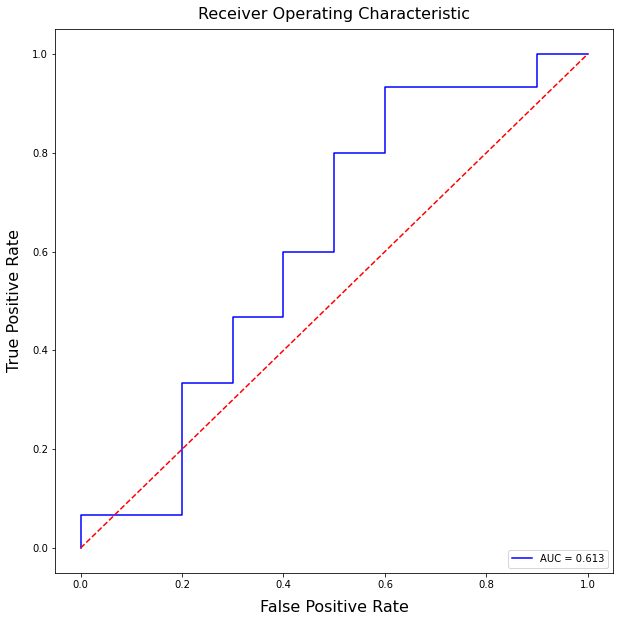

In [65]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

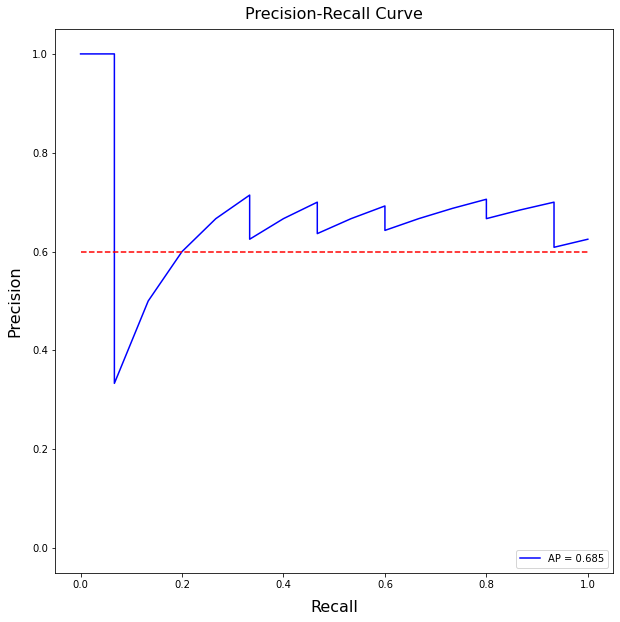

In [66]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [67]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "replica_replica_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.585
Balanced  Accuracy: 0.588
Precision: 0.821
Recall: 0.583
F1 score: 0.682



Next, let's plot the roc curve spectra-wise:

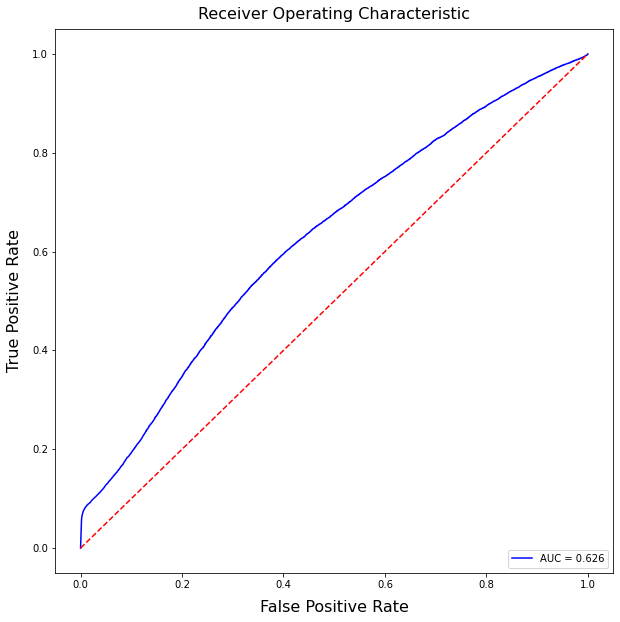

In [68]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

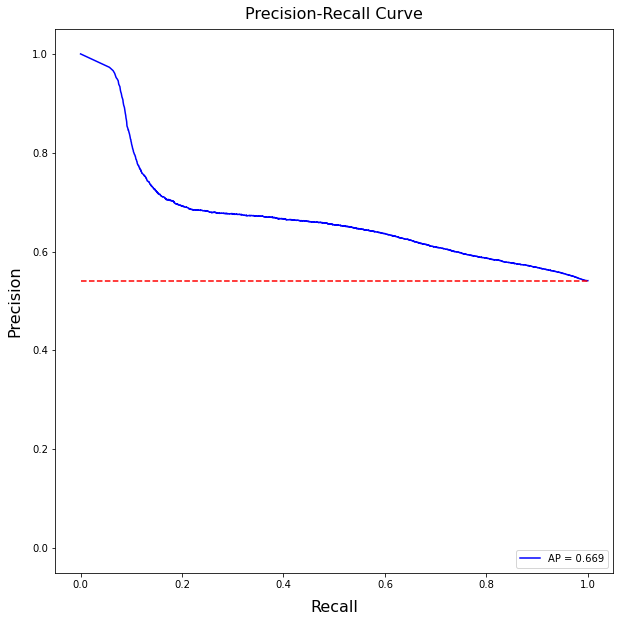

In [69]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

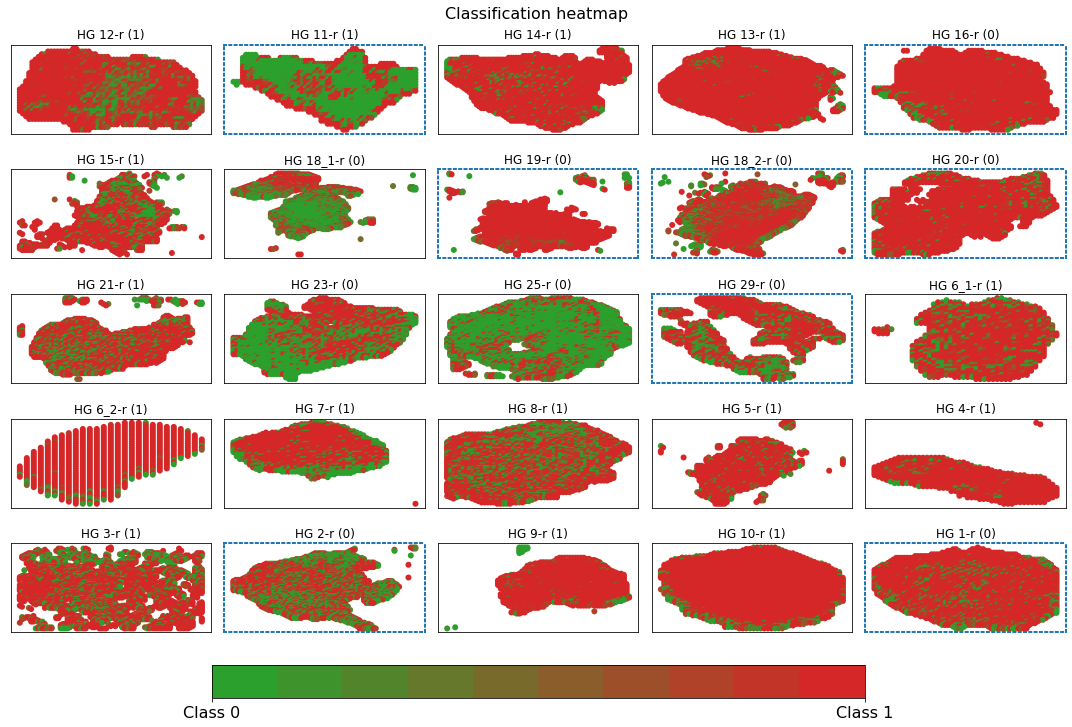

In [70]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

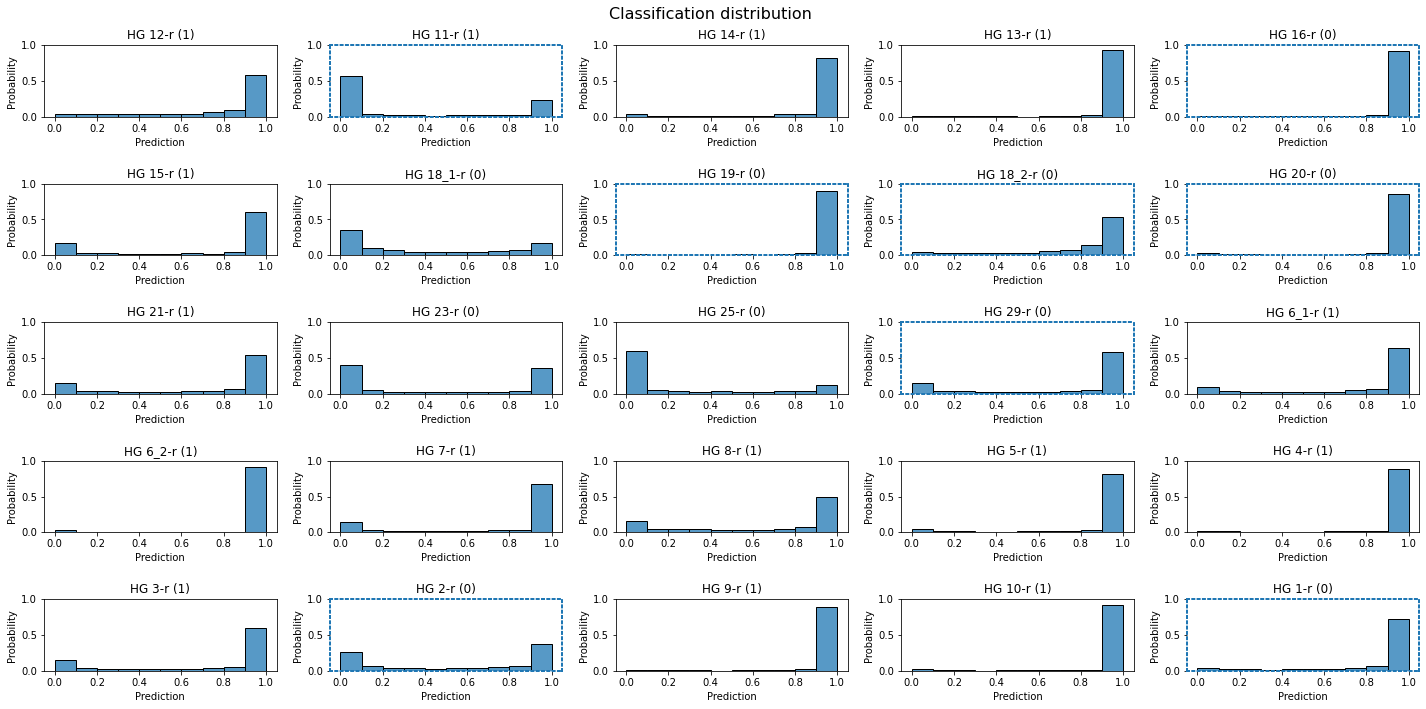

In [71]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [72]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica non-tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [73]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      ~r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"replica_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [02:55<00:00,  7.01s/it]


Next, let's get some statistics about each left out section sample predictions:

In [74]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/replica_replica_non_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 12-r                    0.0000000000            1.0000000000   
HG 11-r                    0.0000000070            1.0000000000   
HG 14-r                    0.0000000060            1.0000000000   
HG 13-r                    0.0000001559            1.0000000000   
HG 16-r                    0.0000000000            1.0000000000   
HG 15-r                    0.0000000000            1.0000000000   
HG 18_1-r                  0.0000000088            1.0000000000   
HG 19-r                    0.0000000001            1.0000000000   
HG 18_2-r                  0.0000000079            1.0000000000   
HG 20-r                    0.0000000004            1.0000000000   
HG 21-r                    0.0000000000            1.0000000000   
HG 23-r                    0.0000000000            1.0000000000   
HG 25-r                    0.0000000000            1.0000000000   
HG 29-r                    0.0000000000            1.0000000000   
HG 6_1-r                   0.0000000000            1.0000000000   
HG 6_2-r                   0.0000000535            1.0000000000   
HG 7-r                     0.0000000000            1.0000000000   
HG 8-r                     0.0000000049            1.0000000000   
HG 5-r                     0.0000000000            1.0000000000   
HG 4-r                     0.0000000000            1.0000000000   
HG 3-r                     0.0000000000            1.0000000000   
HG 2-r                     0.0000000000            1.0000000000   
HG 9-r                     0.0000000000            1.0000000000   
HG 10-r                    0.0000000000            1.0000000000   
HG 1-r                     0.0000000000            1.0000000000   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 12-r                       0.9267725945             0.6578204036   
HG 11-r                       0.9968886375             0.7350895405   
HG 14-r                       0.9962112904             0.7214594483   
HG 13-r                       0.7659876347             0.5562454462   
HG 16-r                       0.9961513877             0.7686786056   
HG 15-r                       0.9404294491             0.6610137820   
HG 18_1-r                     0.8450340033             0.6408566236   
HG 19-r                       0.9984857440             0.8192459941   
HG 18_2-r                     0.9784470797             0.7373788953   
HG 20-r                       0.9966449142             0.8283396959   
HG 21-r                       0.9574407935             0.7194630504   
HG 23-r                       0.9876604080             0.7782203555   
HG 25-r                       0.9767373204             0.7673267126   
HG 29-r                       0.8877430558             0.6398749948   
HG 6_1-r                      0.9977247119             0.8098291755   
HG 6_2-r                      0.9974178672             0.7584195137   
HG 7-r                        0.9780442119             0.6789062023   
HG 8-r                        0.9782218933             0.7602335215   
HG 5-r                        0.9676611423             0.7409486771   
HG 4-r                        0.9762631059             0.7348304391   
HG 3-r                        0.9631683826             0.7093870640   
HG 2-r                        0.9875602126             0.7775380015   
HG 9-r                        0.9105250239             0.6677303910   
HG 10-r                       0.8822214603             0.6234756708   
HG 1-r                        0.9955849648             0.7869125009   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 12-r                    0.4109787643             1                  1  
HG 11-r                    0.3967967033             1           

Next, let's evaluate the classification performance image-wise:

In [75]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "replica_replica_non_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.600
Balanced  Accuracy: 0.500
Precision: 0.600
Recall: 1.000
F1 score: 0.750



Next, let's plot the roc curve image-wise:

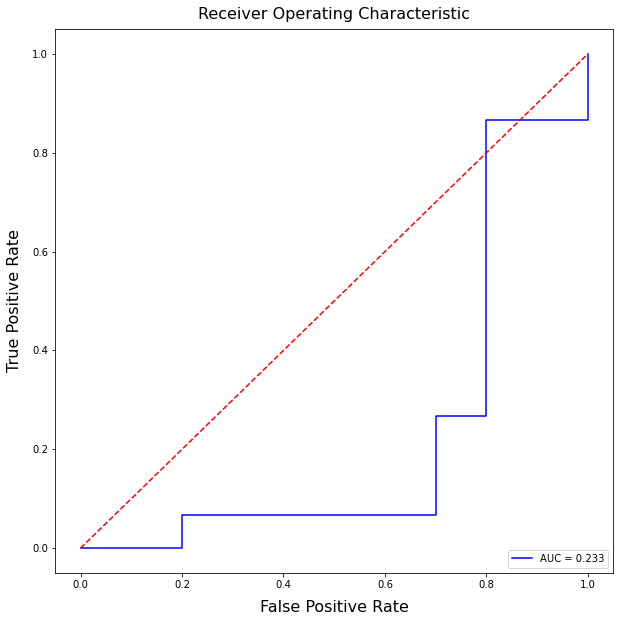

In [76]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

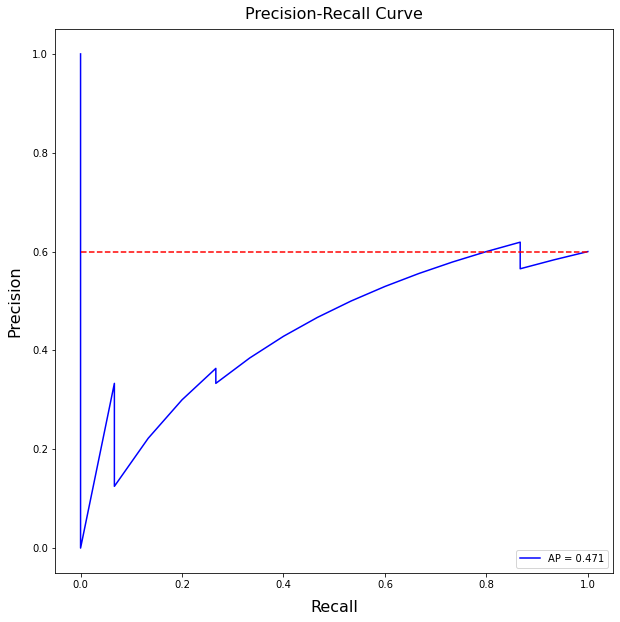

In [77]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [78]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "replica_replica_non_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.510
Balanced  Accuracy: 0.466
Precision: 0.698
Recall: 0.565
F1 score: 0.624



Next, let's plot the roc curve spectra-wise:

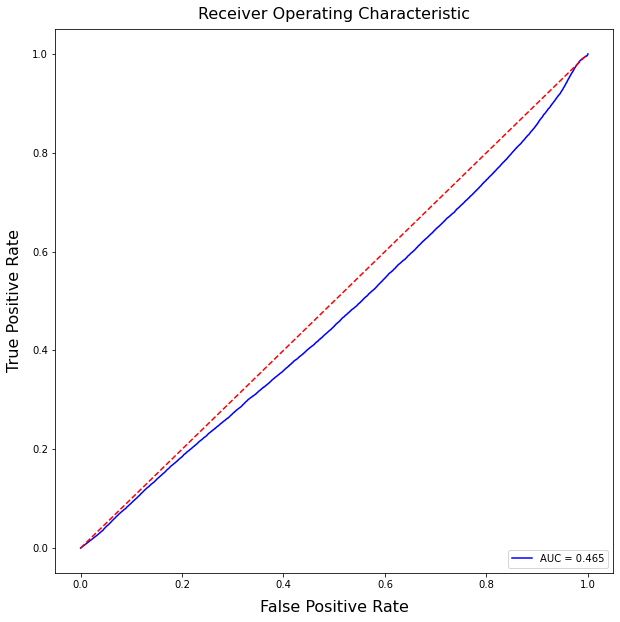

In [79]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

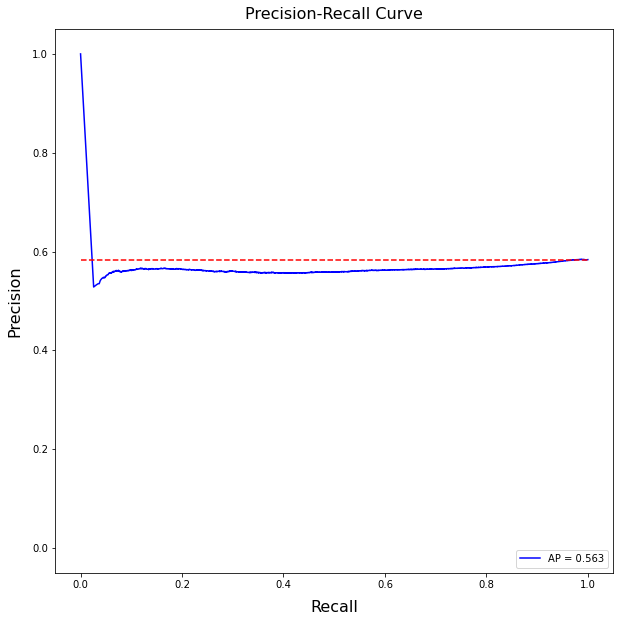

In [80]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

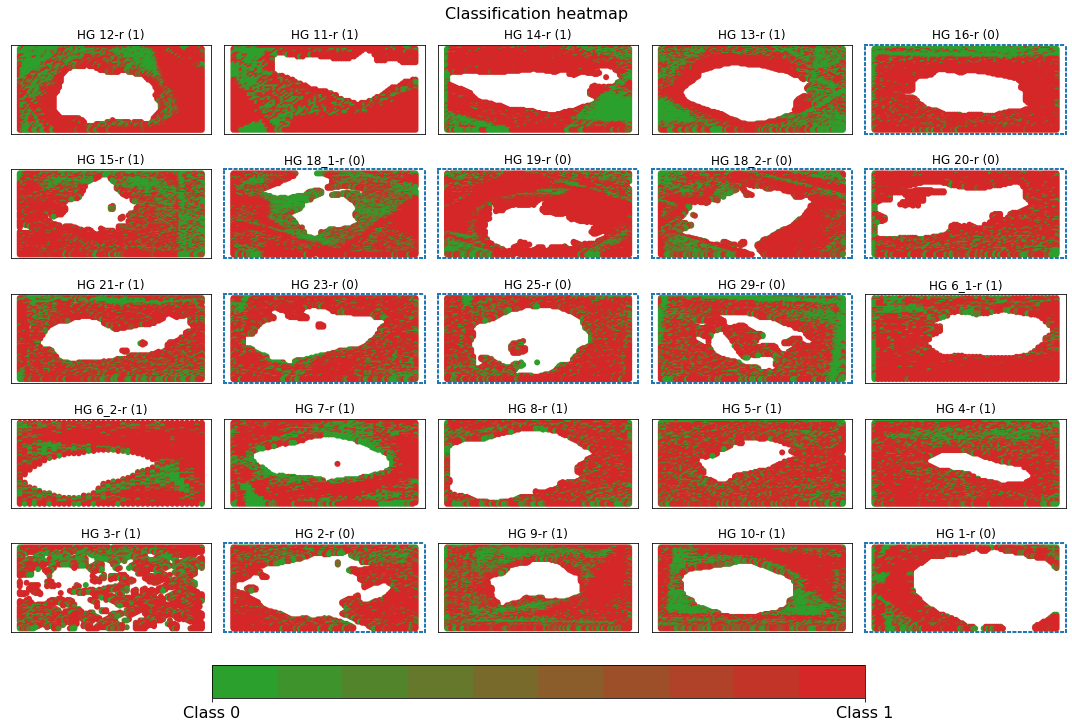

In [81]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

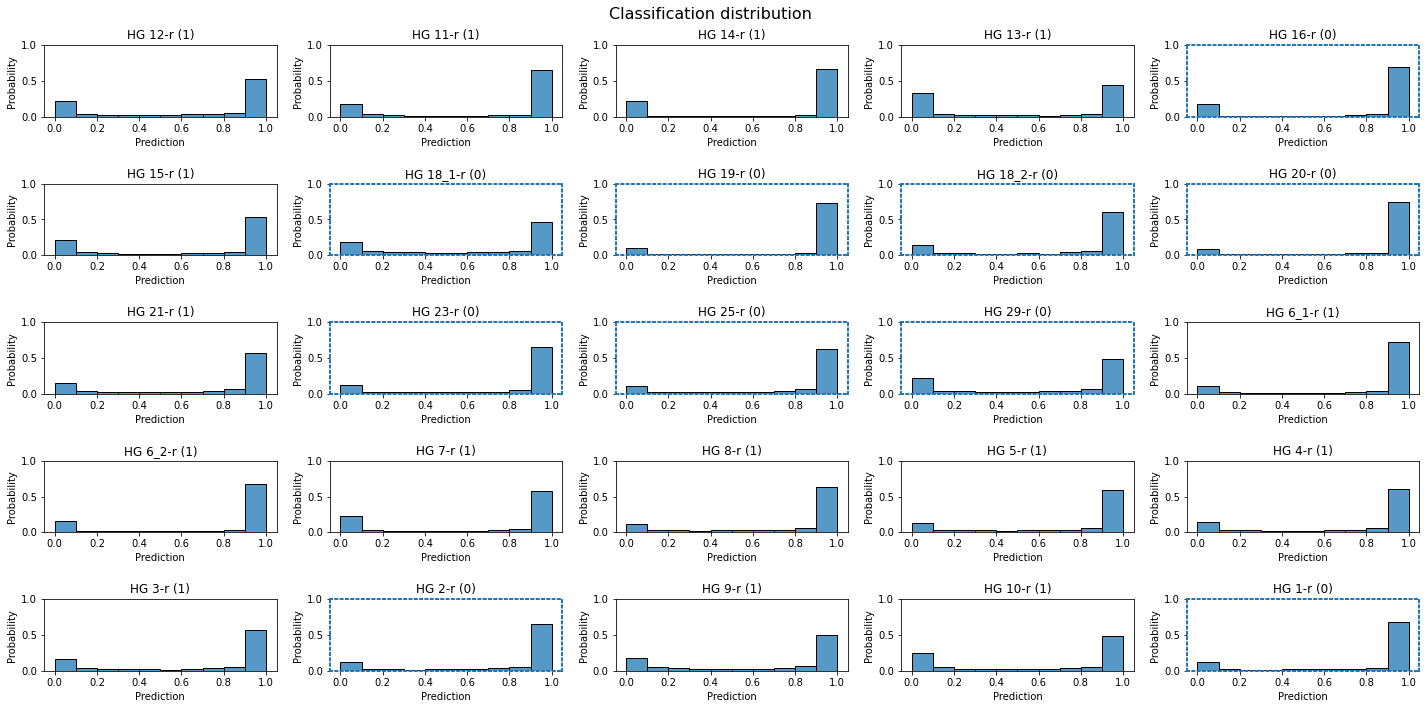

In [82]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [83]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/replica_replica_non_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on section tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [84]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the replica sample_file_name
  r_file_name = r_metadata_df[r_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"replica_excluded_{r_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:38<00:00,  3.95s/it]


Next, let's get some statistics about each left out section sample predictions:

In [85]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/replica_section_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 11_1-s                  0.0000100820            1.0000000000   
HG 11_2-s                  0.0000282971            1.0000000000   
HG 12-s                    0.0000091354            1.0000000000   
HG 14-s                    0.0000033758            1.0000000000   
HG 13-s                    0.0000000003            1.0000000000   
HG 15-s                    0.0000000000            1.0000000000   
HG 16-s                    0.0000000000            1.0000000000   
HG 19-s                    0.0001011621            1.0000000000   
HG 18-s                    0.0000002657            1.0000000000   
HG 20-s                    0.0000098999            1.0000000000   
HG 21-s                    0.0000242421            1.0000000000   
HG 23-s                    0.0000028353            1.0000000000   
HG 25-s                    0.0000004430            1.0000000000   
HG 29-s                    0.0000068844            1.0000000000   
HG 6-s                     0.0000866458            1.0000000000   
HG 7-s                     0.0000118343            1.0000000000   
HG 8-s                     0.0000023142            1.0000000000   
HG 12_1-s                  0.0008071886            1.0000000000   
HG 5-s                     0.0061325445            1.0000000000   
HG 4-s                     0.0056328392            1.0000000000   
HG 3-s                     0.0000066418            1.0000000000   
HG 2-s                     0.0000132357            1.0000000000   
HG 9-s                     0.0000000727            1.0000000000   
HG 10-s                    0.0000002407            0.9999998808   
HG 1-s                     0.0000000018            1.0000000000   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 11_1-s                     0.9999907017             0.8428962827   
HG 11_2-s                     0.9999991655             0.8528263569   
HG 12-s                       0.9944233298             0.6706615686   
HG 14-s                       0.9999976158             0.9731128216   
HG 13-s                       0.1929605603             0.4280541837   
HG 15-s                       0.0260791164             0.4240513444   
HG 16-s                       0.9999991655             0.7760926485   
HG 19-s                       0.9998581409             0.9212390780   
HG 18-s                       0.9478869438             0.7007649541   
HG 20-s                       1.0000000000             0.9641292691   
HG 21-s                       1.0000000000             0.9433307052   
HG 23-s                       1.0000000000             0.9675890803   
HG 25-s                       1.0000000000             0.9574005008   
HG 29-s                       0.9999974966             0.9209550023   
HG 6-s                        1.0000000000             0.9867049456   
HG 7-s                        0.8767324686             0.6359176040   
HG 8-s                        0.9999694824             0.9232794046   
HG 12_1-s                     1.0000000000             0.9833294153   
HG 5-s                        0.9999982119             0.9837200046   
HG 4-s                        0.9999998808             0.9943078160   
HG 3-s                        0.9993284941             0.8635279536   
HG 2-s                        0.9999575615             0.9362629056   
HG 9-s                        0.8281799555             0.6176494360   
HG 10-s                       0.2409394085             0.4266083241   
HG 1-s                        0.8965589404             0.6143987775   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 11_1-s                  0.3330953121             1                  1  
HG 11_2-s                  0.3266291618             1           

Next, let's evaluate the classification performance image-wise:

In [86]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "replica_section_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.520
Balanced  Accuracy: 0.406
Precision: 0.591
Recall: 0.812
F1 score: 0.684



Next, let's plot the roc curve image-wise:

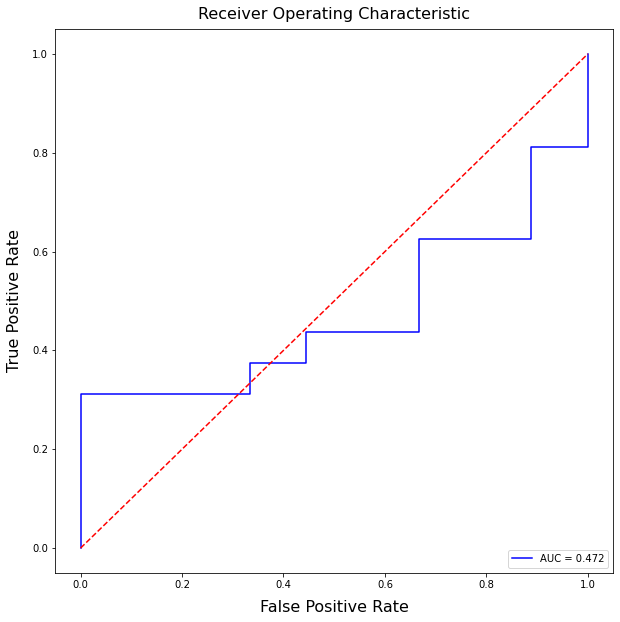

In [87]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

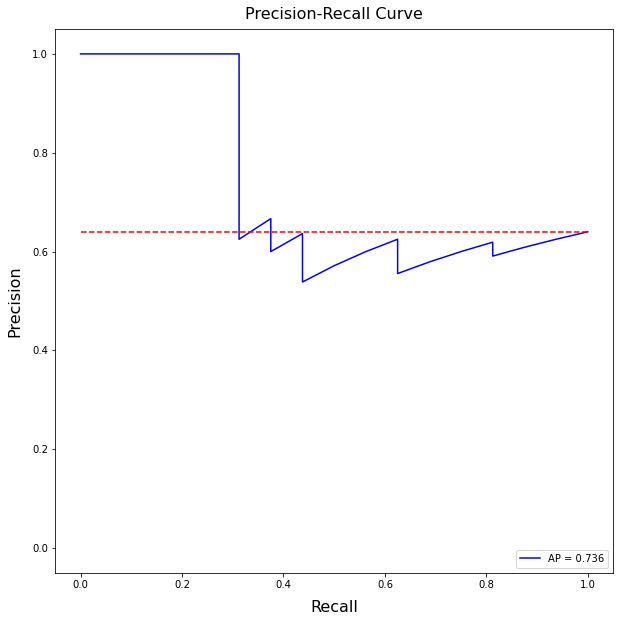

In [88]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [89]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "replica_section_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.544
Balanced  Accuracy: 0.445
Precision: 0.799
Recall: 0.597
F1 score: 0.683



Next, let's plot the roc curve spectra-wise:

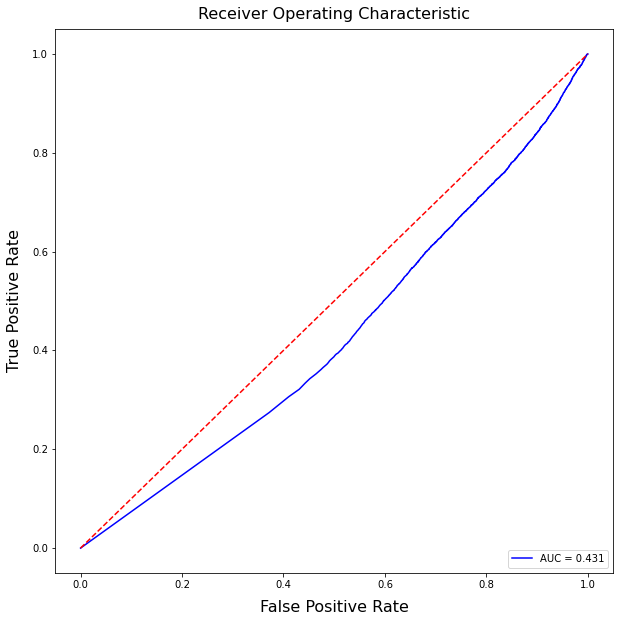

In [90]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

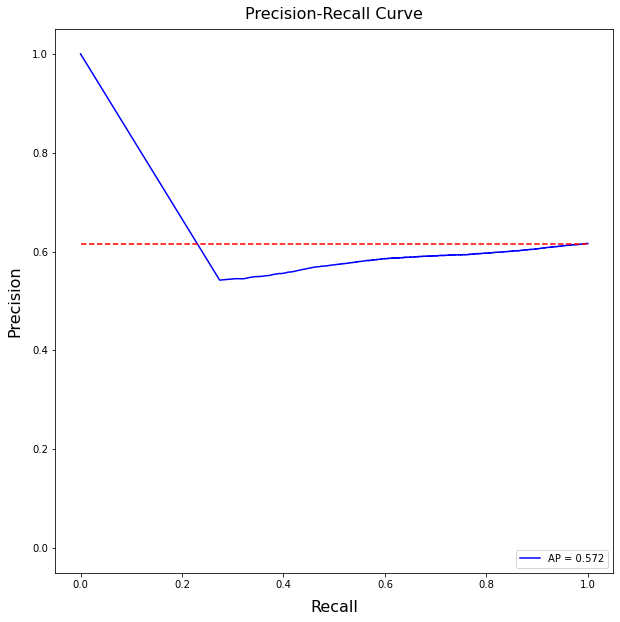

In [91]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

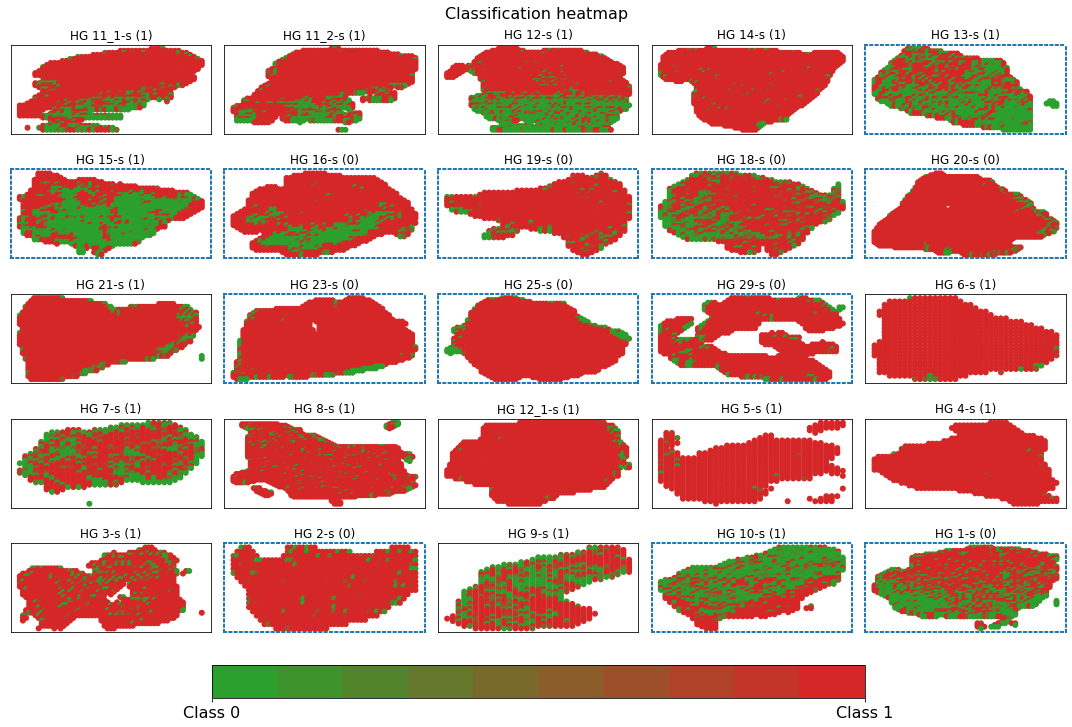

In [92]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

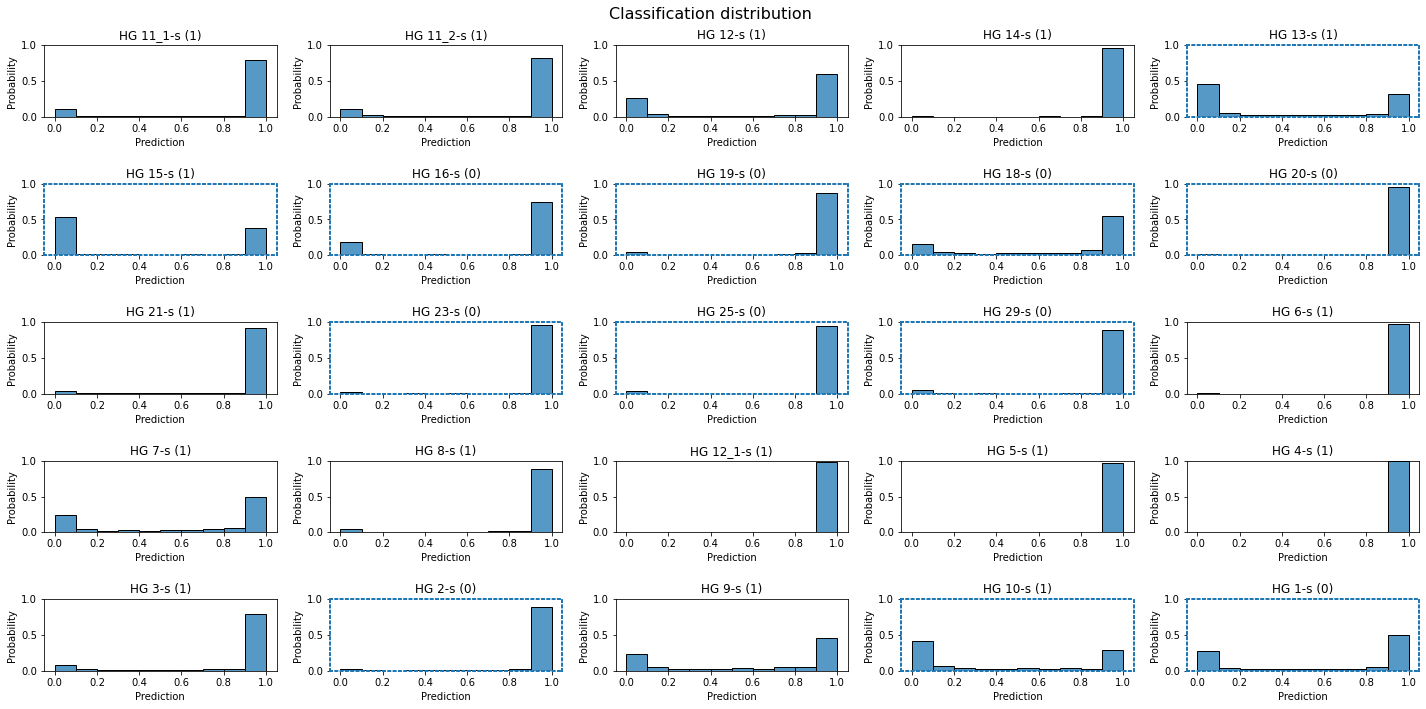

In [93]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [94]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/replica_section_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on section non-tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [95]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  r_file_name = r_metadata_df[r_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      ~s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False, filter_spectra
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"replica_excluded_{r_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [02:26<00:00,  5.87s/it]


Next, let's get some statistics about each left out section sample predictions:

In [96]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/replica_section_non_tissue_pred_stats.csv")
# Print statistics
model_eval

min_spectra_prediction  max_spectra_prediction  \
sample_left_out                                                   
HG 11_1-s                  0.0000000002            1.0000000000   
HG 11_2-s                  0.0000000503            1.0000000000   
HG 12-s                    0.0000000106            1.0000000000   
HG 14-s                    0.0000000000            1.0000000000   
HG 13-s                    0.0000021673            1.0000000000   
HG 15-s                    0.0000000000            1.0000000000   
HG 16-s                    0.0000065780            1.0000000000   
HG 19-s                    0.0000000496            1.0000000000   
HG 18-s                    0.0000156074            1.0000000000   
HG 20-s                    0.0000000001            1.0000000000   
HG 21-s                    0.0000029334            1.0000000000   
HG 23-s                    0.0000001326            1.0000000000   
HG 25-s                    0.0000010578            1.0000000000   
HG 29-s                    0.0000001137            1.0000000000   
HG 6-s                     0.0000000000            1.0000000000   
HG 7-s                     0.0000196267            1.0000000000   
HG 8-s                     0.0000000001            1.0000000000   
HG 12_1-s                  0.0000026634            1.0000000000   
HG 5-s                     0.0000000286            1.0000000000   
HG 4-s                     0.0000000453            1.0000000000   
HG 3-s                     0.0000001484            1.0000000000   
HG 2-s                     0.0000001018            1.0000000000   
HG 9-s                     0.0000000001            1.0000000000   
HG 10-s                    0.0000405857            1.0000000000   
HG 1-s                     0.0000000000            1.0000000000   

                 median_spectra_prediction  mean_spectra_prediction  \
sample_left_out                                                       
HG 11_1-s                     0.9971506596             0.7788703442   
HG 11_2-s                     0.9901737571             0.7129521370   
HG 12-s                       0.9971491098             0.7753633261   
HG 14-s                       0.9979158044             0.8218295574   
HG 13-s                       0.9972589016             0.8202392459   
HG 15-s                       0.9920931458             0.7553998232   
HG 16-s                       0.9919243455             0.7496348023   
HG 19-s                       0.9997796416             0.8776167035   
HG 18-s                       0.9996700883             0.8858405352   
HG 20-s                       0.9778109789             0.7230566144   
HG 21-s                       0.9873171449             0.7689425945   
HG 23-s                       0.9972398281             0.7954311371   
HG 25-s                       0.9952452779             0.7801845670   
HG 29-s                       0.9081466198             0.6333489418   
HG 6-s                        0.9997599721             0.8869723678   
HG 7-s                        0.9998075366             0.8971115351   
HG 8-s                        0.9590189457             0.6449560523   
HG 12_1-s                     0.9939370155             0.7648048997   
HG 5-s                        0.9761699438             0.6609047055   
HG 4-s                        0.9775730371             0.6466007829   
HG 3-s                        0.9767781496             0.6576400995   
HG 2-s                        0.9708017111             0.6688721180   
HG 9-s                        0.9998503327             0.8916116357   
HG 10-s                       0.9998930693             0.9388551116   
HG 1-s                        0.9999016523             0.8896439672   

                 std_spectra_prediction  sample_label  sample_prediction  
sample_left_out                                                           
HG 11_1-s                  0.3696401417             1                  1  
HG 11_2-s                  0.4012673497             1           

Next, let's evaluate the classification performance image-wise:

In [97]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "replica_section_non_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.640
Balanced  Accuracy: 0.500
Precision: 0.640
Recall: 1.000
F1 score: 0.780



Next, let's plot the roc curve image-wise:

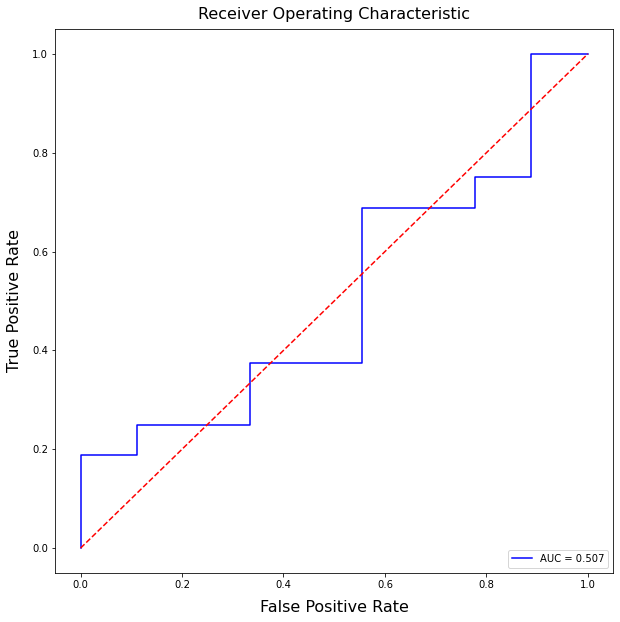

In [98]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

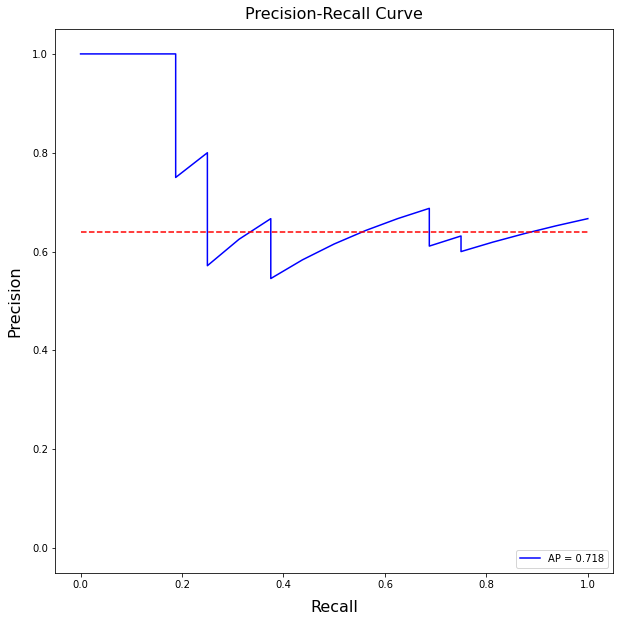

In [99]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [100]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "replica_section_non_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.565
Balanced  Accuracy: 0.500
Precision: 0.768
Recall: 0.622
F1 score: 0.687



Next, let's plot the roc curve spectra-wise:

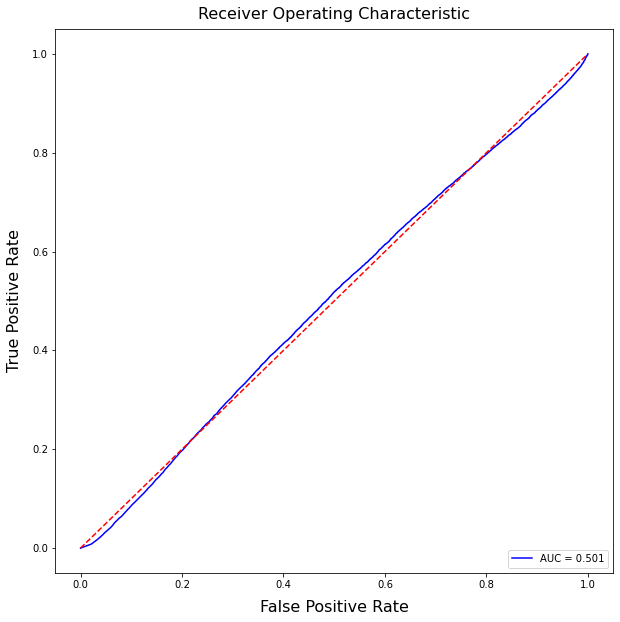

In [101]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

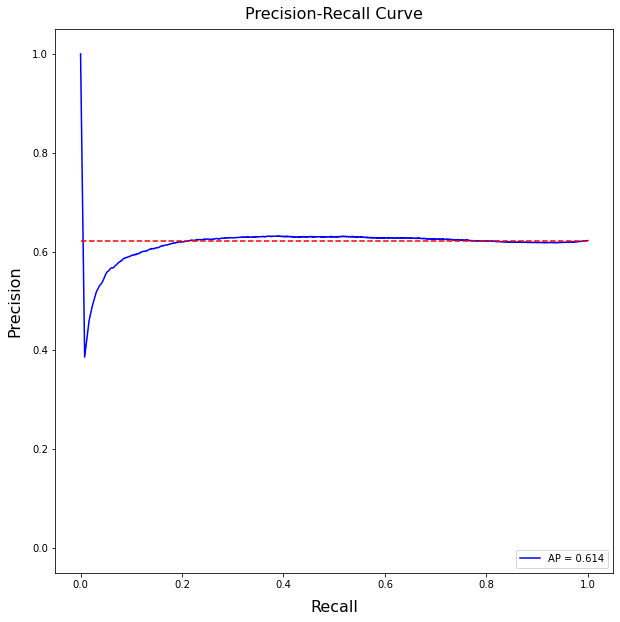

In [102]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

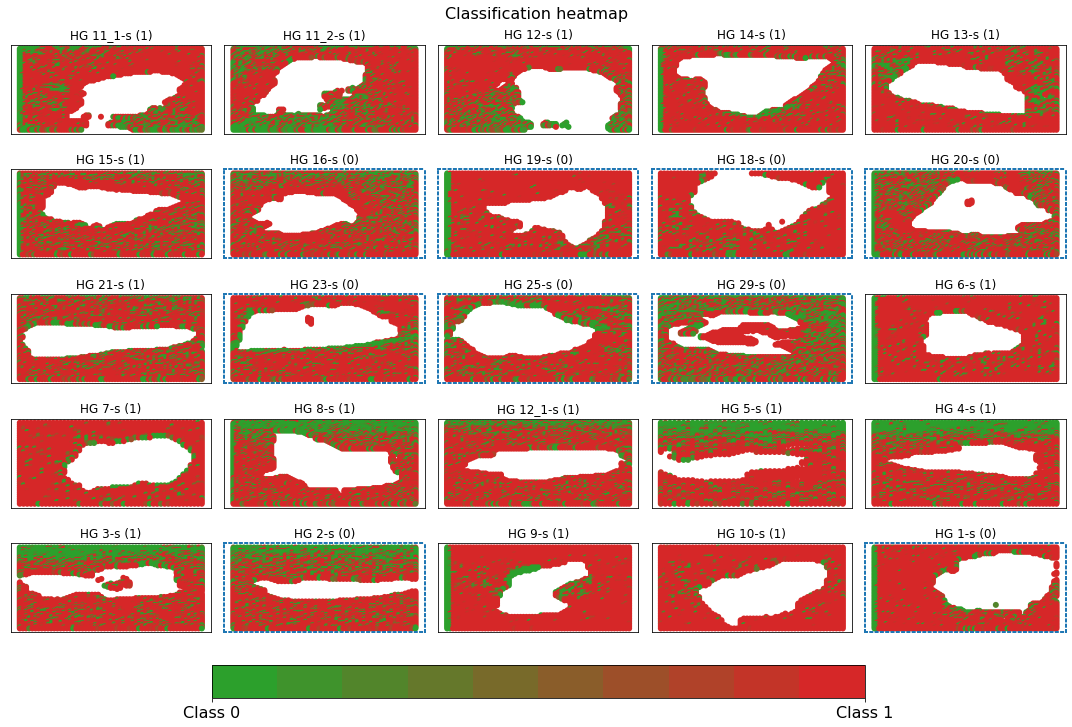

In [103]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

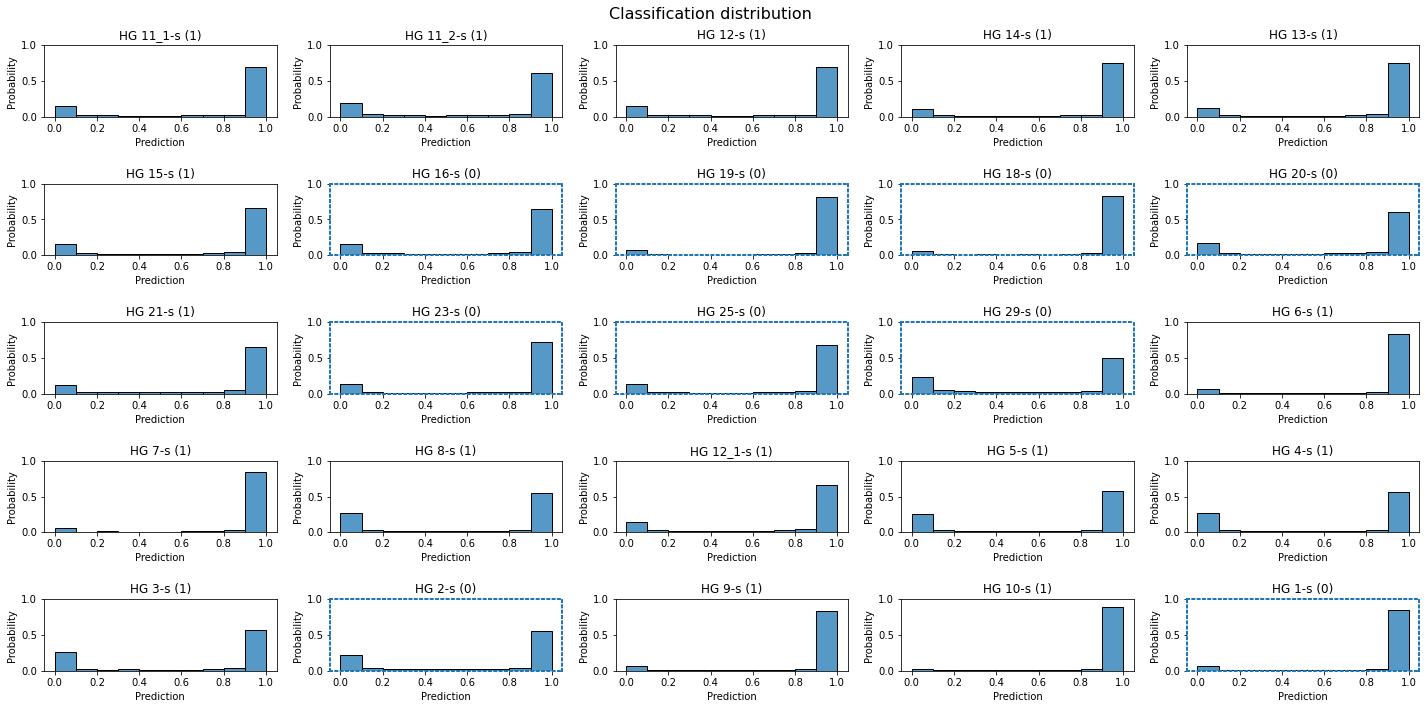

In [104]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_section_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [105]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/replica_section_non_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [106]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()